In [1]:
import pickle  
import mygene
from gseapy import read_gmt
import anndata as ad
import numpy as np
import pandas as pd
import os
mg = mygene.MyGeneInfo()


In [67]:
ajm_file_path = "/labs/Aguiar/SSPA_BRAY/BRay/BRAY_AJM2/2_Data/2_SingleCellData/2_AJM_Parse_Timecourse/GEX_TC_LPSonly_Bcellonly_filt_raw_2024-02-05.rds"
ajm_metadata_path = "/labs/Aguiar/SSPA_BRAY/BRay/BRAY_AJM2/2_Data/2_SingleCellData/2_AJM_Parse_Timecourse/meta_TC_LPSonly_Bcellonly_filt_raw_2024-02-05.csv"


In [3]:
r_script_path = "/labs/Aguiar/SSPA_BRAY/BRay/VariationalInference/rds_to_anndata.R"


In [4]:
import subprocess
import scipy.sparse as sp

In [5]:
result = subprocess.run(["Rscript", r_script_path], 
                        capture_output=True, 
                        text=True, 
                        check=True)
print("R conversion output:")
print(result.stdout)

R conversion output:



In [68]:
sparse_data = pd.read_csv("matrix_sparse.csv")

row_names = pd.read_csv("matrix_rownames.csv")["row_names"].tolist()  
col_names = pd.read_csv("matrix_colnames.csv")["col_names"].tolist()  

matrix_dims = None

matrix_dims = pd.read_csv("matrix_dims.csv")
nrows = matrix_dims["rows"].iloc[0]
ncols = matrix_dims["cols"].iloc[0]
print(f"Matrix dimensions from file: {nrows} x {ncols}")
if nrows != len(row_names) or ncols != len(col_names):
    print(f"WARNING: Dimension mismatch! Row names: {len(row_names)}, Column names: {len(col_names)}")

Matrix dimensions from file: 57010 x 4036


In [69]:
print(f"Sparse data shape: {sparse_data.shape}")
print(f"Number of genes (rows in original matrix): {len(row_names)}")
print(f"Number of cells (columns in original matrix): {len(col_names)}")

Sparse data shape: (10987886, 3)
Number of genes (rows in original matrix): 57010
Number of cells (columns in original matrix): 4036


In [70]:
row_indices = sparse_data["row"].values  
col_indices = sparse_data["col"].values  
values = sparse_data["value"].values

print(f"Row indices range: {row_indices.min()} to {row_indices.max()}")
print(f"Column indices range: {col_indices.min()} to {col_indices.max()}")


print(f"Creating sparse matrix with shape: ({nrows}, {ncols}) and transposing to match AnnData format")

sparse_matrix = sp.coo_matrix((values, (row_indices, col_indices)), 
                                shape=(nrows, ncols))

sparse_matrix = sparse_matrix.transpose().tocsr()

print(f"Transposed matrix shape: {sparse_matrix.shape}")

Row indices range: 0 to 57003
Column indices range: 0 to 4035
Creating sparse matrix with shape: (57010, 4036) and transposing to match AnnData format
Transposed matrix shape: (4036, 57010)


In [71]:
ajm_adata = ad.AnnData(X=sparse_matrix)

In [72]:
ajm_adata.obs_names = col_names  
ajm_adata.var_names = row_names  
ajm_adata.obs_names_make_unique()
ajm_adata.var_names_make_unique()

In [101]:
# FIXED: Load metadata properly handling the unnamed first column
# Load metadata without setting index_col=0 to preserve the unnamed column
ajm_features = pd.read_csv(ajm_metadata_path)

# Rename the first (unnamed) column to 'sample_id'
ajm_features = ajm_features.rename(columns={ajm_features.columns[0]: 'sample_id'})

print("Fixed metadata columns:")
print(ajm_features.columns.tolist())
print("\nFirst few rows of fixed metadata:")
print(ajm_features.head())

# Apply label mapping
ajm_label_mapping = {
    'TC-0hr':       {'ap':0,'cyto':0,'ig':-1},
    'TC-LPS-3hr':   {'ap':-1,'cyto':0,'ig':-1},
    'TC-LPS-6hr':   {'ap':1,'cyto':-1,'ig':-1},
    'TC-LPS-24hr':  {'ap':1,'cyto':1,'ig':-1},
    'TC-LPS-48hr':  {'ap':-1,'cyto':-1,'ig':-1},
    'TC-LPS-72hr':  {'ap':-1,'cyto':-1,'ig':-1},
}

for col in ['ap','cyto','ig']:
    ajm_features[col] = None

for sample_value, labels in ajm_label_mapping.items():
    mask = ajm_features['sample'] == sample_value
    for col in labels:
        ajm_features.loc[mask,col] = labels[col]

# Set sample_id as index for matching with AnnData
ajm_features.set_index('sample_id', inplace=True)

# Now match with the AnnData object
common_cells_ajm = ajm_adata.obs_names.intersection(ajm_features.index)
print(f"\nNumber of common cells: {len(common_cells_ajm)}")

# Subset AnnData to common cells
ajm_adata = ajm_adata[common_cells_ajm].copy()
ajm_features = ajm_features.loc[common_cells_ajm]

# Add metadata to AnnData object
for col in ajm_features.columns:
    ajm_adata.obs[col] = ajm_features[col].values

# IMPORTANT: Add sample_id back as a regular column
ajm_adata.obs['sample_id'] = ajm_features.index.values

# Ensure gene symbols are available
if 'gene_symbols' not in ajm_adata.var:
    ajm_adata.var['gene_symbols'] = ajm_adata.var_names

# Create the cyto samples subset
ajm_cyto_samples = ajm_adata[ajm_adata.obs['cyto'].isin([0,1])].copy()
ajm_cyto_samples.raw = ajm_cyto_samples.copy()
ajm_cyto_samples.obs['dataset'] = 'cyto'

print(f"\nFixed AnnData shape: {ajm_cyto_samples.shape}")
print("Sample IDs in fixed AnnData:")
print(ajm_cyto_samples.obs['sample_id'].head())

Fixed metadata columns:
['sample_id', 'UMAP1', 'UMAP2', 'source', 'sample', 'tissue', 'geno', 'clusters', 'stim']

First few rows of fixed metadata:
            sample_id     UMAP1     UMAP2 source  sample tissue    geno  \
0  34_01_27__s1_WT100  4.224976  1.241554  WT100  TC-0hr     TC  TC-0hr   
1  34_01_53__s1_WT100  3.207547  5.890696  WT100  TC-0hr     TC  TC-0hr   
2  34_01_60__s1_WT100  4.305446  4.431521  WT100  TC-0hr     TC  TC-0hr   
3  34_02_20__s1_WT100  6.146047  4.542736  WT100  TC-0hr     TC  TC-0hr   
4  34_03_35__s1_WT100  4.045040  1.999378  WT100  TC-0hr     TC  TC-0hr   

   clusters stim  
0         3  0hr  
1         3  0hr  
2         3  0hr  
3         3  0hr  
4         3  0hr  

Number of common cells: 4036

Fixed AnnData shape: (2666, 57010)
Sample IDs in fixed AnnData:
34_01_27__s1_WT100    34_01_27__s1_WT100
34_01_53__s1_WT100    34_01_53__s1_WT100
34_01_60__s1_WT100    34_01_60__s1_WT100
34_02_20__s1_WT100    34_02_20__s1_WT100
34_03_35__s1_WT100    34_03

In [102]:
ajm_cyto_samples

AnnData object with n_obs × n_vars = 2666 × 57010
    obs: 'UMAP1', 'UMAP2', 'source', 'sample', 'tissue', 'geno', 'clusters', 'stim', 'ap', 'cyto', 'ig', 'sample_id', 'dataset'
    var: 'gene_symbols'

In [103]:
cell_totals = np.array(ajm_cyto_samples.X.sum(axis=1)).flatten()
print(f"Median total counts per cell: {np.median(cell_totals)}")
print(f"Mean total counts per cell: {np.mean(cell_totals)}")

Median total counts per cell: 3670.0
Mean total counts per cell: 8010.965866466617


In [104]:
def QCscRNAsizeFactorNormOnly(
    adata: ad,
    layer: str = None,
    key_added: str = 'size_factors'
) -> ad:

    if adata.is_view:
        adata = adata.copy()

    X = adata.X if layer is None else adata.layers[layer]
    X = X.astype(float) 

    if sp.issparse(X):
        UMI_counts_per_cell = np.array(X.sum(axis=1)).flatten()
    else:
        UMI_counts_per_cell = X.sum(axis=1)

    adata.obs['total_counts'] = UMI_counts_per_cell

    median_UMI = np.median(UMI_counts_per_cell)


    scaling_factors = np.divide(median_UMI, UMI_counts_per_cell,
                                out=np.zeros_like(UMI_counts_per_cell, dtype=float),
                                where=UMI_counts_per_cell!=0)

    if key_added:
        adata.obs[key_added] = scaling_factors

    if sp.issparse(X):
        scaling_matrix = sp.diags(scaling_factors)
        adata.X = scaling_matrix @ X
    else:
        adata.X = X * scaling_factors[:, np.newaxis]

    return adata

In [105]:
ajm_cyto_normalized = QCscRNAsizeFactorNormOnly(ajm_cyto_samples)


In [106]:
cell_totals = np.array(ajm_cyto_normalized.X.sum(axis=1)).flatten()
print(f"Median total counts per cell: {np.median(cell_totals)}")
print(f"Mean total counts per cell: {np.mean(cell_totals)}")

Median total counts per cell: 3670.0
Mean total counts per cell: 3670.0


In [107]:
print(ajm_cyto_normalized)

AnnData object with n_obs × n_vars = 2666 × 57010
    obs: 'UMAP1', 'UMAP2', 'source', 'sample', 'tissue', 'geno', 'clusters', 'stim', 'ap', 'cyto', 'ig', 'sample_id', 'dataset', 'total_counts', 'size_factors'
    var: 'gene_symbols'


In [108]:
import scanpy as sc
sc.pp.log1p(ajm_cyto_normalized)

In [109]:
ajm_cyto_samples.obs['cyto']

34_01_27__s1_WT100    0
34_01_53__s1_WT100    0
34_01_60__s1_WT100    0
34_02_20__s1_WT100    0
34_03_35__s1_WT100    0
                     ..
39_86_93__s8_WT100    0
39_87_48__s8_WT100    0
39_87_60__s8_WT100    0
39_89_66__s8_WT100    0
39_92_24__s8_WT100    0
Name: cyto, Length: 2666, dtype: object

In [110]:
gene_annotation_path = "/labs/Aguiar/SSPA_BRAY/BRay/BRAY_FileTransfer/ENS_mouse_geneannotation.csv"
gene_annotation = pd.read_csv(gene_annotation_path)
gene_annotation = gene_annotation.set_index('GeneID')

In [111]:
def filter_protein_coding_genes(adata, gene_annotation):
    protein_coding_genes = gene_annotation[gene_annotation['Genetype'] == 'protein_coding'].index
    
    common_genes = np.intersect1d(adata.var_names, protein_coding_genes)
    
    print(f"Total genes: {adata.n_vars}")
    print(f"Protein-coding genes found: {len(common_genes)}")
    
    adata_filtered = adata[:, common_genes].copy()
    
    return adata_filtered

In [112]:
ajm_cyto_filtered = filter_protein_coding_genes(ajm_cyto_normalized, gene_annotation)

Total genes: 57010
Protein-coding genes found: 21501


In [113]:
import numpy as np
import pandas as pd
import scanpy as sc
import gseapy
import matplotlib.pyplot as plt
import warnings
import os
import subprocess

In [114]:
ensembl_ids = ajm_cyto_filtered.var_names.tolist()
gene_info_df = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='mouse', as_dataframe=True)
gene_map = gene_info_df['symbol'].dropna().to_dict()
new_var_names = [gene_map.get(eid, eid) for eid in ajm_cyto_filtered.var_names]
ajm_cyto_filtered.var_names = new_var_names
ajm_cyto_filtered.var_names_make_unique()
print(ajm_cyto_filtered)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found dup hits:	[('ENSMUSG00000072694', 2)]
94 input query terms found no hit:	['ENSMUSG00000022591', 'ENSMUSG00000034007', 'ENSMUSG00000040715', 'ENSMUSG00000040838', 'ENSMUSG000


AnnData object with n_obs × n_vars = 2666 × 21501
    obs: 'UMAP1', 'UMAP2', 'source', 'sample', 'tissue', 'geno', 'clusters', 'stim', 'ap', 'cyto', 'ig', 'sample_id', 'dataset', 'total_counts', 'size_factors'
    var: 'gene_symbols'
    uns: 'log1p'


In [115]:
print(f"Data shape: {ajm_cyto_filtered.X.shape}")
cell_totals = np.array(ajm_cyto_filtered.X.sum(axis=1)).flatten()
print(f"Median total counts per cell: {np.median(cell_totals)}")
print(f"Mean total counts per cell: {np.mean(cell_totals)}")

Data shape: (2666, 21501)
Median total counts per cell: 1379.8820702717308
Mean total counts per cell: 1416.988717953017


In [117]:
print("Cell counts per 'cyto' group:")
print(ajm_cyto_filtered.obs['cyto'].value_counts())
ajm_cyto_filtered.obs['cyto'] = ajm_cyto_filtered.obs['cyto'].astype('category')
print("\nData type of 'cyto' column after conversion:")
print(ajm_cyto_filtered.obs['cyto'].dtype)

Cell counts per 'cyto' group:
cyto
0    2060
1     606
Name: count, dtype: int64

Data type of 'cyto' column after conversion:
category


In [118]:
print(f"Original number of genes: {ajm_cyto_filtered.n_vars}")

sc.pp.filter_genes(ajm_cyto_filtered, min_cells=30)

print(f"Number of genes after filtering: {ajm_cyto_filtered.n_vars}")

Original number of genes: 21501
Number of genes after filtering: 10891


In [119]:
print(ajm_cyto_filtered.obs['cyto'].dtype)


category


In [120]:
ajm_cyto_filtered.obs['cyto'].cat.categories

Index([0, 1], dtype='int64')

In [121]:
ajm_cyto_filtered.obs['cyto'] = ajm_cyto_filtered.obs['cyto'].astype(int).astype('category')

In [122]:
ajm_cyto_filtered.obs['cyto'].cat.categories

Index([0, 1], dtype='int64')

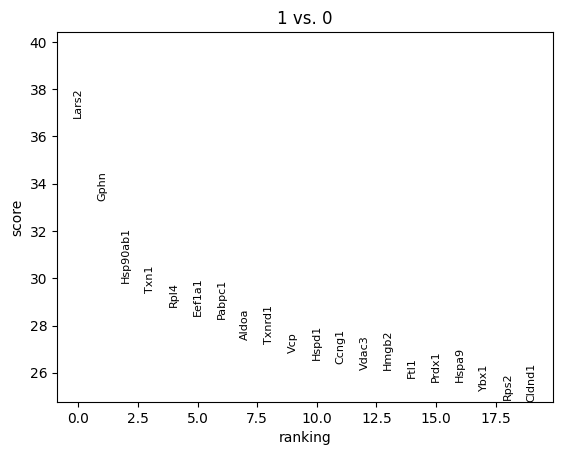

In [32]:
sc.tl.rank_genes_groups(
    ajm_cyto_filtered,
    groupby='cyto',
    method='wilcoxon',       # Specify the group(s) you want to test (e.g., group '1')
    reference=0,       # Explicitly set '0' as the reference group
    use_raw=False
)
sc.pl.rank_genes_groups(ajm_cyto_filtered, n_genes=20, sharey=False, show=True)

In [33]:
cyto1_vs_0_results_df = sc.get.rank_genes_groups_df(ajm_cyto_filtered, group='1')

fdr_threshold = 0.05  
lfc_threshold = 1.0   

upregulated_genes = cyto1_vs_0_results_df[
    (cyto1_vs_0_results_df['pvals_adj'] < fdr_threshold) & 
    (cyto1_vs_0_results_df['logfoldchanges'] > lfc_threshold)
]

downregulated_genes = cyto1_vs_0_results_df[
    (cyto1_vs_0_results_df['pvals_adj'] < fdr_threshold) & 
    (cyto1_vs_0_results_df['logfoldchanges'] < -lfc_threshold)
]

print(f"Found {len(upregulated_genes)} significantly UPREGULATED genes in 'cyto=1' vs 'cyto=0'.")
print("Top 10 upregulated genes:")
print(upregulated_genes.head(10))

print("-" * 50)

print(f"\nFound {len(downregulated_genes)} significantly DOWNREGULATED genes in 'cyto=1' vs 'cyto=0'.")
print("Top 10 downregulated genes:")
print(downregulated_genes.head(10))

upregulated_genes.to_csv("cyto1_vs_0_upregulated_genes.csv")
downregulated_genes.to_csv("cyto1_vs_0_downregulated_genes.csv")

Found 3241 significantly UPREGULATED genes in 'cyto=1' vs 'cyto=0'.
Top 10 upregulated genes:
      names     scores  logfoldchanges          pvals      pvals_adj
0     Lars2  36.804493        2.786065  1.564690e-296  1.704104e-292
1      Gphn  33.297302        1.751227  4.224488e-243  2.300445e-239
2  Hsp90ab1  29.794941        1.909904  4.542990e-195  1.649257e-191
3      Txn1  29.403898        3.822841  4.896219e-190  1.333118e-186
4      Rpl4  28.795437        1.793741  2.446516e-182  4.440834e-179
5    Eef1a1  28.419434        1.764910  1.163393e-177  1.810073e-174
6    Pabpc1  28.265352        1.767236  9.218537e-176  1.254989e-172
7     Aldoa  27.387001        2.864480  3.917418e-165  4.740511e-162
8    Txnrd1  27.221273        2.730352  3.637829e-163  3.961960e-160
9       Vcp  26.834072        2.313560  1.294159e-158  1.281335e-155
--------------------------------------------------

Found 119 significantly DOWNREGULATED genes in 'cyto=1' vs 'cyto=0'.
Top 10 downregulated genes

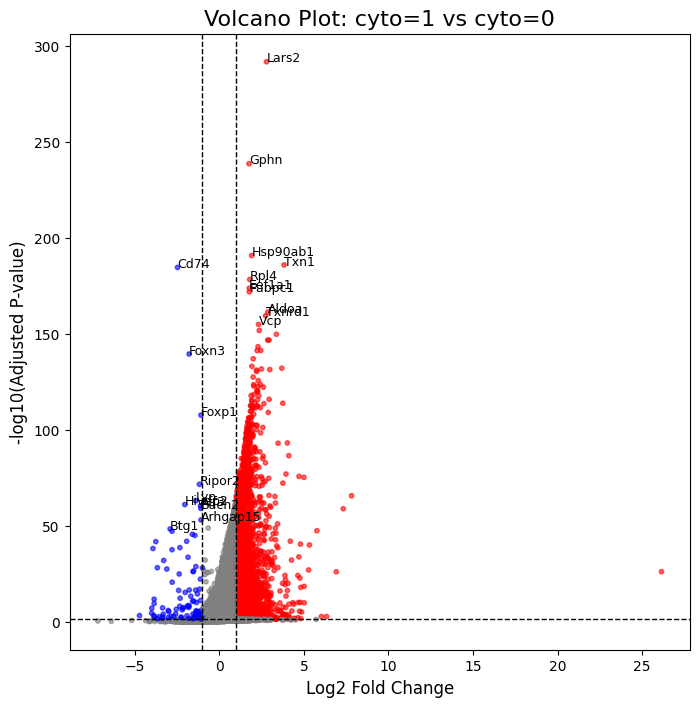

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume you have your results in this dataframe from the previous step
# cyto1_vs_0_results_df = sc.get.rank_genes_groups_df(ajm_cyto_filtered, group='1')

# --- Manual Volcano Plot ---

# 1. Prepare the data for plotting
# We need log2foldchanges on the x-axis and -log10(adjusted p-value) on the y-axis
df_for_plot = cyto1_vs_0_results_df.copy()

# Calculate the -log10 p-value. We add a tiny number to avoid log(0) errors.
df_for_plot['-log10_pvals_adj'] = -np.log10(df_for_plot['pvals_adj'] + 1e-300)

# 2. Define colors for significant/non-significant genes
# We'll use the same thresholds as before
fdr_threshold = 0.05
lfc_threshold = 1.0

# Create a new column to hold color labels
df_for_plot['color'] = 'grey' # Default to grey
df_for_plot.loc[(df_for_plot['pvals_adj'] < fdr_threshold) & (df_for_plot['logfoldchanges'] > lfc_threshold), 'color'] = 'red'
df_for_plot.loc[(df_for_plot['pvals_adj'] < fdr_threshold) & (df_for_plot['logfoldchanges'] < -lfc_threshold), 'color'] = 'blue'

# 3. Create the plot
plt.figure(figsize=(8, 8))
plt.scatter(
    x=df_for_plot['logfoldchanges'],
    y=df_for_plot['-log10_pvals_adj'],
    c=df_for_plot['color'],
    s=10, # size of points
    alpha=0.6 # transparency
)

# 4. Add threshold lines
plt.axhline(y=-np.log10(fdr_threshold), color='black', linestyle='--', linewidth=1)
plt.axvline(x=lfc_threshold, color='black', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_threshold, color='black', linestyle='--', linewidth=1)

# 5. Add labels and title
plt.title("Volcano Plot: cyto=1 vs cyto=0", fontsize=16)
plt.xlabel("Log2 Fold Change", fontsize=12)
plt.ylabel("-log10(Adjusted P-value)", fontsize=12)
plt.grid(False) # Turn off the background grid

# Optional: Add labels for the top genes to make the plot more informative
# Get top 10 upregulated and top 10 downregulated genes
top_up = df_for_plot[df_for_plot['color']=='red'].nlargest(10, '-log10_pvals_adj')
top_down = df_for_plot[df_for_plot['color']=='blue'].nlargest(10, '-log10_pvals_adj')
top_genes = pd.concat([top_up, top_down])

for i, row in top_genes.iterrows():
    plt.text(row['logfoldchanges'], row['-log10_pvals_adj'], row['names'], fontsize=9)

plt.show()

In [35]:
cytobeam_csv_path = "/labs/Aguiar/SSPA_BRAY/BRay/BRAY_AJM2/2_Data/1_ASGs/CYTOBEAM_genes.csv"

CYTOBEAM_df = pd.read_csv(cytobeam_csv_path)

CYTOBEAM = CYTOBEAM_df.iloc[:, 0].tolist()

print(f"Number of genes in CYTOBEAM: {len(CYTOBEAM)}")

Number of genes in CYTOBEAM: 420


In [36]:
# --- Analysis of CYTOBEAM Gene Set Overlap with DGE Results ---

# Convert the CYTOBEAM gene list to a set for efficient lookups
cytobeam_set = set(CYTOBEAM)

# 1. Find which CYTOBEAM genes are in the list of significantly UPREGULATED genes
upregulated_cytobeam_genes = upregulated_genes[upregulated_genes['names'].isin(cytobeam_set)]

# 2. Find which CYTOBEAM genes are in the list of significantly DOWNREGULATED genes
downregulated_cytobeam_genes = downregulated_genes[downregulated_genes['names'].isin(cytobeam_set)]

# 3. Get the DGE statistics for ALL CYTOBEAM genes that were detected in the experiment
all_cytobeam_dge_stats = cyto1_vs_0_results_df[cyto1_vs_0_results_df['names'].isin(cytobeam_set)].copy()
# Sort by log fold change to see the most up- and down-regulated genes at the top and bottom
all_cytobeam_dge_stats.sort_values('logfoldchanges', ascending=False, inplace=True)


# --- Print the Summary ---

print(f"Total genes in CYTOBEAM signature: {len(CYTOBEAM)}")
print(f"Total CYTOBEAM genes detected in the experiment: {len(all_cytobeam_dge_stats)}")
print("-" * 60)

print(f"\nFound {len(upregulated_cytobeam_genes)} CYTOBEAM genes among the significantly UPREGULATED genes:")
# Display the details for these genes
with pd.option_context('display.max_rows', 10):
    print(upregulated_cytobeam_genes[['names', 'logfoldchanges', 'pvals_adj']])

print("\n" + "-" * 60)

print(f"\nFound {len(downregulated_cytobeam_genes)} CYTOBEAM genes among the significantly DOWNREGULATED genes:")
# Display the details for these genes
with pd.option_context('display.max_rows', 10):
    print(downregulated_cytobeam_genes[['names', 'logfoldchanges', 'pvals_adj']])

print("\n" + "-" * 60)

print("\nFull DGE statistics for all detected CYTOBEAM genes (sorted by Log2 Fold Change):")
# Display the full list to see the overall trend
with pd.option_context('display.max_rows', len(all_cytobeam_dge_stats)):
    print(all_cytobeam_dge_stats[['names', 'logfoldchanges', 'pvals_adj']])

Total genes in CYTOBEAM signature: 420
Total CYTOBEAM genes detected in the experiment: 378
------------------------------------------------------------

Found 99 CYTOBEAM genes among the significantly UPREGULATED genes:
        names  logfoldchanges      pvals_adj
12      Vdac3        2.853605  1.826820e-147
13      Hmgb2        2.938640  1.826820e-147
20       Ezh2        2.489365  1.966844e-132
43      Gapdh        2.634612  2.345096e-114
61       Tcp1        1.759755  9.605290e-107
...       ...             ...            ...
8539    Cebpb        1.341177   8.130570e-03
8620    Rbbp9        1.334557   1.156623e-02
8632   Cxcl10        2.646691   1.196616e-02
8729  Dynlt1c        1.166577   1.838620e-02
8956      Osm        1.651701   4.405586e-02

[99 rows x 3 columns]

------------------------------------------------------------

Found 14 CYTOBEAM genes among the significantly DOWNREGULATED genes:
         names  logfoldchanges      pvals_adj
8736    Bcl2l1       -1.367119   1.905

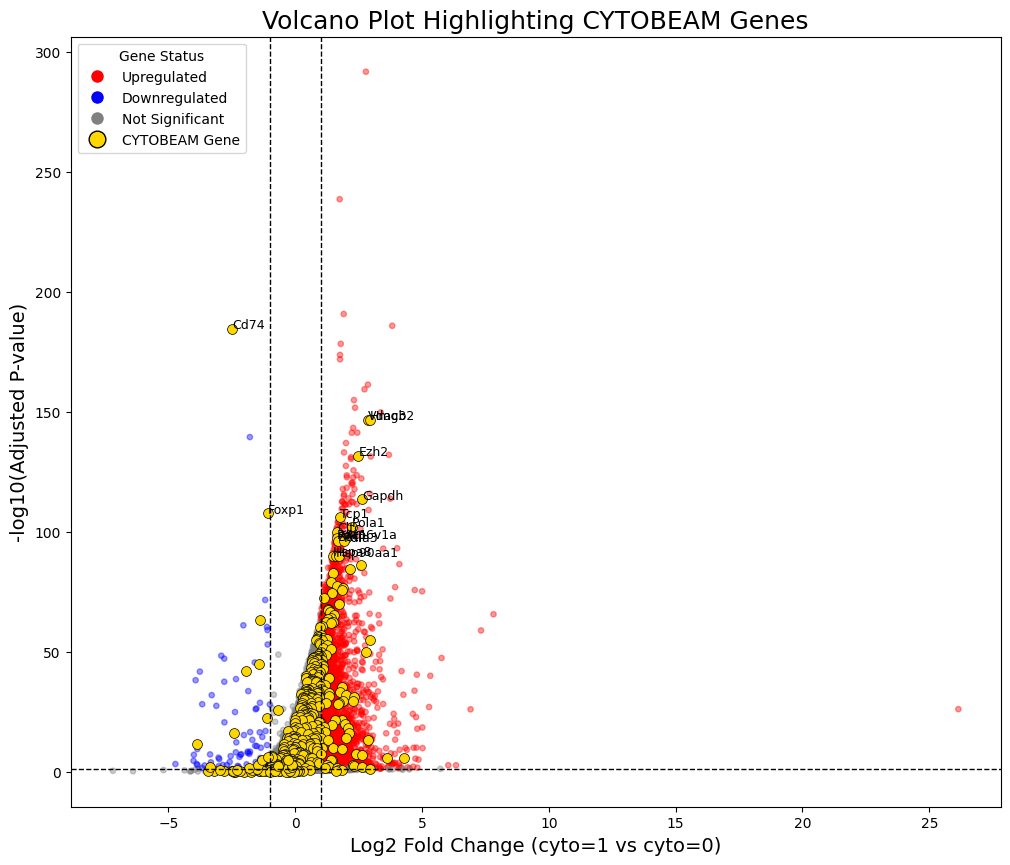

In [37]:
from matplotlib.lines import Line2D

# --- Enhanced Volcano Plot with CYTOBEAM Highlighting ---

# 1. Get the list of CYTOBEAM gene names that are present in our DGE results
cytobeam_genes_in_data = set(all_cytobeam_dge_stats['names'])

# 2. Create the base plot
plt.figure(figsize=(12, 10))

# Plot all genes with the standard red/blue/grey coloring from the 'color' column
plt.scatter(
    x=df_for_plot['logfoldchanges'],
    y=df_for_plot['-log10_pvals_adj'],
    c=df_for_plot['color'],
    s=15, # point size
    alpha=0.4 # transparency
)

# 3. Overlay the CYTOBEAM genes to highlight them
# Filter the main dataframe to get the coordinates for CYTOBEAM genes
cytobeam_plot_data = df_for_plot[df_for_plot['names'].isin(cytobeam_genes_in_data)]

plt.scatter(
    x=cytobeam_plot_data['logfoldchanges'],
    y=cytobeam_plot_data['-log10_pvals_adj'],
    c='gold',
    s=50, # make them larger
    alpha=1.0,
    edgecolors='black', # add a border to make them stand out
    linewidth=0.5
)

# 4. Add threshold lines (same as before)
plt.axhline(y=-np.log10(fdr_threshold), color='black', linestyle='--', linewidth=1)
plt.axvline(x=lfc_threshold, color='black', linestyle='--', linewidth=1)
plt.axvline(x=-lfc_threshold, color='black', linestyle='--', linewidth=1)

# 5. Add labels and title
plt.title("Volcano Plot Highlighting CYTOBEAM Genes", fontsize=18)
plt.xlabel("Log2 Fold Change (cyto=1 vs cyto=0)", fontsize=14)
plt.ylabel("-log10(Adjusted P-value)", fontsize=14)
plt.grid(False)

# 6. Annotate the most significant CYTOBEAM genes
# Get significant CYTOBEAM genes and sort by p-value to find the top ones
top_cytobeam_to_label = cytobeam_plot_data.nlargest(15, '-log10_pvals_adj')

for i, row in top_cytobeam_to_label.iterrows():
    plt.text(row['logfoldchanges'], row['-log10_pvals_adj'], row['names'], fontsize=9)

# 7. Create a custom legend to explain the colors
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Upregulated', markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Downregulated', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Not Significant', markerfacecolor='grey', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='CYTOBEAM Gene', 
           markerfacecolor='gold', markeredgecolor='black', markersize=12)
]
plt.legend(handles=legend_elements, title='Gene Status', loc='upper left')

plt.show()

In [38]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.metrics import ConfusionMatrixDisplay
import gzip
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve
from scipy.stats import pearsonr, spearmanr
import sys

In [39]:
def load_experiment_data(instance_path):
    dfs = {
        "pathways": None,
        "statistics": None,
        "train_stats": None,
        "test_stats": None, 
        "val_stats": None
    }

    if not os.path.isdir(instance_path):
        print(f"Error: Directory not found at {instance_path}")
        return tuple(dfs.values())

    for filename in os.listdir(instance_path):
        file_path = os.path.join(instance_path, filename)
        
        # Skip if not a file
        if not os.path.isfile(file_path):
            continue

        try:
            if 'analysis' in filename and filename.endswith('.json.gz'):
                print(f"Attempting to load {filename} (analysis JSON)...")
                with gzip.open(file_path, 'rt', encoding='utf-8') as f:
                    data = json.load(f)
                dfs['pathways'] = pd.DataFrame(data) 
                print(f"Successfully created DataFrame for {filename}")
            elif 'results' in filename and filename.endswith('.json.gz'):
                with gzip.open(file_path, 'rt', encoding='utf-8') as f:
                    data = json.load(f)
                if isinstance(data, dict):
                    dfs['statistics'] = pd.DataFrame([data])
                elif isinstance(data, list): 
                    dfs['statistics'] = pd.DataFrame(data)
                else:
                    print(f"Warning: statistics file {filename} has an unexpected main data type: {type(data)}. Could not convert to DataFrame.")
            elif 'train' in filename and filename.endswith('.csv.gz'):
                dfs['train_stats'] = pd.read_csv(file_path, compression='gzip')
            elif 'test' in filename and filename.endswith('.csv.gz'):
                dfs['test_stats'] = pd.read_csv(file_path, compression='gzip')
            elif 'val' in filename and filename.endswith('.csv.gz'):
                dfs['val_stats'] = pd.read_csv(file_path, compression='gzip')
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
    return dfs['pathways'], dfs['statistics'], dfs['train_stats'], dfs['test_stats'], dfs['val_stats']

In [40]:
def analyze_statistics(statistics_df):
    row_data = statistics_df.iloc[0]
    train_metrics=row_data['train_metrics']
    test_metrics=row_data['test_metrics']
    val_metrics=row_data['val_metrics']

    metrics_list = [
        {'set': 'train', 'metrics': train_metrics},
        {'set': 'validation', 'metrics': val_metrics},
        {'set': 'test', 'metrics': test_metrics}
    ]
    
    metrics_df = pd.DataFrame([
        {'Set': 'Train', **train_metrics},
        {'Set': 'Validation', **val_metrics},
        {'Set': 'Test', **test_metrics}
    ])

    print("Metrics Summary Table:")
    print("=" * 80)
    print(metrics_df.to_string(index=False, float_format='%.4f'))
    print("=" * 80)

    print(f"\nAvailable metrics: {list(train_metrics.keys())}")
    
    return metrics_list, metrics_df

In [41]:
best_exp="/labs/Aguiar/SSPA_BRAY/BRay/Results/pathway_initiated/20250624_174803"

In [42]:
best_pathways, best_statistics, best_train_stats, best_test_stats, best_val_stats = load_experiment_data(best_exp)

Attempting to load ajm_cyto_cyto_initialized_pw1272_gene_program_analysis.json.gz (analysis JSON)...
Successfully created DataFrame for ajm_cyto_cyto_initialized_pw1272_gene_program_analysis.json.gz


In [48]:
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, confusion_matrix
import pandas as pd

# Create interactive plots for model evaluation
import plotly.graph_objects as go
import plotly.express as px

# Combine all datasets for comprehensive analysis
datasets = {
    'Train': best_train_stats,
    'Validation': best_val_stats, 
    'Test': best_test_stats
}

# 1. ROC Curve Plot
fig_roc = go.Figure()

for name, df in datasets.items():
    fpr, tpr, _ = roc_curve(df['true_label'], df['probability'])
    roc_auc = auc(fpr, tpr)
    
    fig_roc.add_trace(go.Scatter(
        x=fpr, y=tpr,
        mode='lines',
        name=f'{name} (AUC = {roc_auc:.3f})',
        line=dict(width=2)
    ))

# Add diagonal line
fig_roc.add_trace(go.Scatter(
    x=[0, 1], y=[0, 1],
    mode='lines',
    name='Random Classifier',
    line=dict(dash='dash', color='gray')
))

fig_roc.update_layout(
    title='ROC Curves for All Datasets',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=600, height=500
)

fig_roc.show()

# 2. Confusion Matrix Plots
fig_cm = make_subplots(
    rows=1, cols=3,
    subplot_titles=['Train', 'Validation', 'Test'],
    specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"}]]
)

for i, (name, df) in enumerate(datasets.items(), 1):
    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    
    fig_cm.add_trace(
        go.Heatmap(
            z=cm,
            x=['Predicted 0', 'Predicted 1'],
            y=['True 0', 'True 1'],
            colorscale='Blues',
            showscale=(i==1),
            text=cm,
            texttemplate="%{text}",
            textfont={"size": 14}
        ),
        row=1, col=i
    )

fig_cm.update_layout(
    title='Confusion Matrices',
    width=900, height=350
)

fig_cm.show()

# 3. Probability Distribution Plots
fig_dist = make_subplots(
    rows=1, cols=3,
    subplot_titles=['Train', 'Validation', 'Test']
)

for i, (name, df) in enumerate(datasets.items(), 1):
    # Separate probabilities by true label
    prob_0 = df[df['true_label'] == 0]['probability']
    prob_1 = df[df['true_label'] == 1]['probability']
    
    fig_dist.add_trace(
        go.Histogram(
            x=prob_0,
            name=f'{name} - True Label 0',
            opacity=0.7,
            nbinsx=30,
            legendgroup=f'group{i}',
            marker_color='red'
        ),
        row=1, col=i
    )
    
    fig_dist.add_trace(
        go.Histogram(
            x=prob_1,
            name=f'{name} - True Label 1',
            opacity=0.7,
            nbinsx=30,
            legendgroup=f'group{i}',
            marker_color='blue'
        ),
        row=1, col=i
    )

fig_dist.update_layout(
    title='Probability Distributions by True Label',
    width=1200, height=400,
    barmode='overlay'
)

fig_dist.update_xaxes(title_text="Predicted Probability")
fig_dist.update_yaxes(title_text="Count")

fig_dist.show()

# 4. Performance Metrics Summary
metrics_summary = []
for name, df in datasets.items():
    cm = confusion_matrix(df['true_label'], df['predicted_label'])
    fpr, tpr, _ = roc_curve(df['true_label'], df['probability'])
    roc_auc = auc(fpr, tpr)
    
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    metrics_summary.append({
        'Dataset': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': roc_auc,
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn
    })

metrics_df_detailed = pd.DataFrame(metrics_summary)

# Interactive metrics table
fig_metrics = go.Figure(data=[go.Table(
    header=dict(values=list(metrics_df_detailed.columns),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[metrics_df_detailed[col] for col in metrics_df_detailed.columns],
               fill_color='lavender',
               align='left',
               format=[None, '.4f', '.4f', '.4f', '.4f', '.4f', None, None, None, None]))
])

fig_metrics.update_layout(title="Detailed Performance Metrics", width=800, height=300)
fig_metrics.show()

print("Interactive plots created successfully!")
print("\nDetailed Metrics Summary:")
print(metrics_df_detailed.round(4))

Interactive plots created successfully!

Detailed Metrics Summary:
      Dataset  Accuracy  Precision  Recall  F1-Score  AUC-ROC  True Positives  \
0       Train    0.9582     0.9282  0.8844    0.9058   0.9803             375   
1  Validation    0.7625     0.0000  0.0000    0.0000   0.9447               0   
2        Test    0.7825     0.0000  0.0000    0.0000   0.9531               0   

   True Negatives  False Positives  False Negatives  
0            1413               29               49  
1             305                0               95  
2             313                0               87  


In [ ]:
ajm_cyto_filtered.obs['sample_id']

Series([], Name: sample_id, dtype: category
Categories (0, object): [])

In [49]:
best_test_stats

,sample_id,true_label,probability,predicted_label,cyto_seed_score
0,34_15_22__s8_WT100,0.0,0.0244,0,4
1,41_37_70__s2_WT100,1.0,0.0292,0,3
2,34_39_25__s8_WT100,0.0,0.0251,0,2
3,41_46_43__s3_WT100,1.0,0.0264,0,3
4,34_07_48__s2_WT100,0.0,0.0245,0,3
...,...,...,...,...,...
395,39_42_89__s3_WT100,0.0,0.0277,0,2
396,41_76_05__s8_WT100,1.0,0.0289,0,0
397,34_06_17__s8_WT100,0.0,0.0245,0,0
398,41_03_88__s3_WT100,1.0,0.0281,0,1


In [1]:
best_train_stats

NameError: name 'best_train_stats' is not defined

In [123]:
print("Samples in ajm_cyto_filtered:")
print(ajm_cyto_filtered.obs['sample'].unique())

Samples in ajm_cyto_filtered:
['TC-0hr' 'TC-LPS-24hr' 'TC-LPS-3hr']


In [124]:
# Get the 80th and 20th percentiles of the probability column
prob_80 = best_test_stats['probability'].quantile(0.8)
prob_20 = best_test_stats['probability'].quantile(0.2)

# Select columns of interest
cols = ['sample_id', 'true_label', 'probability', 'predicted_label', 'cyto_seed_score']

# DataFrame for top 80% probability group (probability >= 80th percentile)
top_80_df = best_test_stats[best_test_stats['probability'] >= prob_80][cols].reset_index(drop=True)

# DataFrame for bottom 20% probability group (probability <= 20th percentile)
bottom_20_df = best_test_stats[best_test_stats['probability'] <= prob_20][cols].reset_index(drop=True)

print("Top 80% probability group:")
print(top_80_df)

print("\nBottom 20% probability group:")
print(bottom_20_df)


Top 80% probability group:
             sample_id  true_label  probability  predicted_label  \
0   41_37_70__s2_WT100         1.0       0.0292                0   
1   41_46_91__s7_WT100         1.0       0.0295                0   
2   41_28_44__s8_WT100         1.0       0.0287                0   
3   41_40_91__s6_WT100         1.0       0.0288                0   
4   41_62_36__s4_WT100         1.0       0.0297                0   
..                 ...         ...          ...              ...   
80  41_28_24__s6_WT100         1.0       0.0292                0   
81  41_77_84__s8_WT100         1.0       0.0293                0   
82  41_12_77__s3_WT100         1.0       0.0294                0   
83  41_76_05__s8_WT100         1.0       0.0289                0   
84  41_03_88__s3_WT100         1.0       0.0281                0   

    cyto_seed_score  
0                 3  
1                 2  
2                 3  
3                 0  
4                 3  
..              ...  
80

In [133]:
top_80_df

,sample_id,true_label,probability,predicted_label,cyto_seed_score
0,41_37_70__s2_WT100,1.0,0.0292,0,3
1,41_46_91__s7_WT100,1.0,0.0295,0,2
2,41_28_44__s8_WT100,1.0,0.0287,0,3
3,41_40_91__s6_WT100,1.0,0.0288,0,0
4,41_62_36__s4_WT100,1.0,0.0297,0,3
...,...,...,...,...,...
80,41_28_24__s6_WT100,1.0,0.0292,0,0
81,41_77_84__s8_WT100,1.0,0.0293,0,0
82,41_12_77__s3_WT100,1.0,0.0294,0,0
83,41_76_05__s8_WT100,1.0,0.0289,0,0


In [134]:
bottom_20_df

,sample_id,true_label,probability,predicted_label,cyto_seed_score
0,34_34_21__s1_WT100,0.0,0.0233,0,0
1,34_51_54__s2_WT100,0.0,0.0226,0,0
2,34_52_10__s5_WT100,0.0,0.0237,0,2
3,34_25_54__s5_WT100,0.0,0.0229,0,2
4,34_01_52__s3_WT100,0.0,0.0232,0,5
...,...,...,...,...,...
79,34_11_96__s2_WT100,0.0,0.0224,0,0
80,34_78_70__s4_WT100,0.0,0.0234,0,2
81,34_50_16__s3_WT100,0.0,0.0239,0,0
82,34_69_54__s3_WT100,0.0,0.0233,0,4


In [139]:
top_adata = ajm_cyto_filtered[ajm_cyto_filtered.obs['sample_id'].isin(top_80_df['sample_id'])]
bottom_adata = ajm_cyto_filtered[ajm_cyto_filtered.obs['sample_id'].isin(bottom_20_df['sample_id'])]

In [140]:
top_adata

View of AnnData object with n_obs × n_vars = 85 × 10891
    obs: 'UMAP1', 'UMAP2', 'source', 'sample', 'tissue', 'geno', 'clusters', 'stim', 'ap', 'cyto', 'ig', 'sample_id', 'dataset', 'total_counts', 'size_factors'
    var: 'gene_symbols', 'n_cells'
    uns: 'log1p'

In [141]:
ajm_cyto_filtered.obs['sample_id']

34_01_27__s1_WT100    34_01_27__s1_WT100
34_01_53__s1_WT100    34_01_53__s1_WT100
34_01_60__s1_WT100    34_01_60__s1_WT100
34_02_20__s1_WT100    34_02_20__s1_WT100
34_03_35__s1_WT100    34_03_35__s1_WT100
                             ...        
39_86_93__s8_WT100    39_86_93__s8_WT100
39_87_48__s8_WT100    39_87_48__s8_WT100
39_87_60__s8_WT100    39_87_60__s8_WT100
39_89_66__s8_WT100    39_89_66__s8_WT100
39_92_24__s8_WT100    39_92_24__s8_WT100
Name: sample_id, Length: 2666, dtype: object

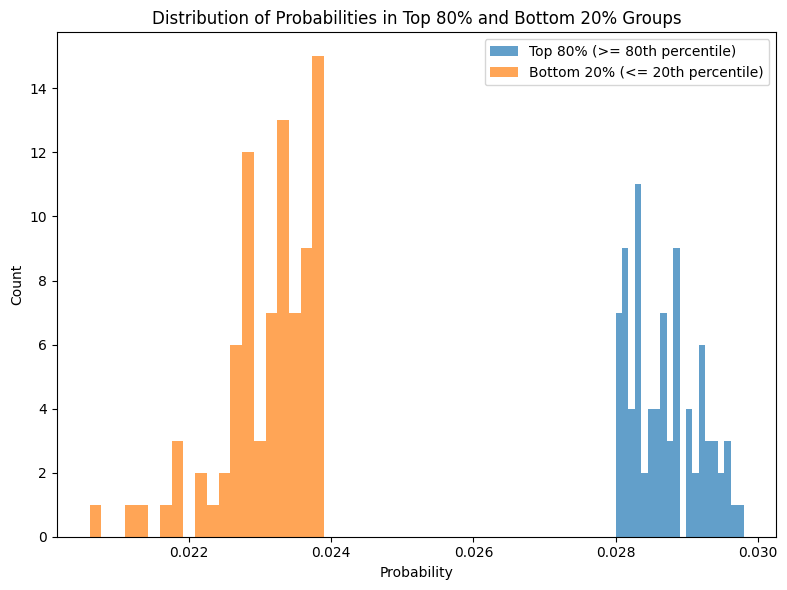

In [142]:
import matplotlib.pyplot as plt

# Plot the distribution of probabilities for each group in a single plot
plt.figure(figsize=(8, 6))
plt.hist(top_80_df['probability'], bins=20, alpha=0.7, label='Top 80% (>= 80th percentile)', color='tab:blue')
plt.hist(bottom_20_df['probability'], bins=20, alpha=0.7, label='Bottom 20% (<= 20th percentile)', color='tab:orange')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Distribution of Probabilities in Top 80% and Bottom 20% Groups')
plt.legend()
plt.tight_layout()
plt.show()


In [143]:
# Extract gene expression data for top 80% and bottom 20% samples
# Get the gene expression matrix for top 80% samples
top_80_expression = top_adata.X.toarray() if hasattr(top_adata.X, 'toarray') else top_adata.X
top_80_expression_df = pd.DataFrame(
    top_80_expression, 
    index=top_adata.obs['sample_id'],
    columns=top_adata.var['gene_symbols']
)

# Get the gene expression matrix for bottom 20% samples  
bottom_20_expression = bottom_adata.X.toarray() if hasattr(bottom_adata.X, 'toarray') else bottom_adata.X
bottom_20_expression_df = pd.DataFrame(
    bottom_20_expression,
    index=bottom_adata.obs['sample_id'], 
    columns=bottom_adata.var['gene_symbols']
)

# Add group labels to the expression dataframes
top_80_expression_df['group'] = 'top_80'
bottom_20_expression_df['group'] = 'bottom_20'

# Combine the expression data
combined_expression_df = pd.concat([top_80_expression_df, bottom_20_expression_df], axis=0)

# Merge with the original prediction dataframes to include probability and other metadata
top_80_with_expression = top_80_df.merge(
    top_80_expression_df, 
    left_on='sample_id', 
    right_index=True, 
    how='left'
)

bottom_20_with_expression = bottom_20_df.merge(
    bottom_20_expression_df,
    left_on='sample_id', 
    right_index=True,
    how='left'
)

# Combine both groups
all_samples_with_expression = pd.concat([top_80_with_expression, bottom_20_with_expression], axis=0)

print("Shape of combined expression data:", all_samples_with_expression.shape)
print("\nColumns in the combined dataframe:")
print(all_samples_with_expression.columns.tolist()[:10], "...")  # Show first 10 columns
print("\nSample of the combined data:")
print(all_samples_with_expression[['sample_id', 'true_label', 'probability', 'predicted_label', 'cyto_seed_score', 'group']].head())


Shape of combined expression data: (169, 10897)

Columns in the combined dataframe:
['sample_id', 'true_label', 'probability', 'predicted_label', 'cyto_seed_score', 'ENSMUSG00000000001', 'ENSMUSG00000000028', 'ENSMUSG00000000056', 'ENSMUSG00000000078', 'ENSMUSG00000000085'] ...

Sample of the combined data:
            sample_id  true_label  probability  predicted_label  \
0  41_37_70__s2_WT100         1.0       0.0292                0   
1  41_46_91__s7_WT100         1.0       0.0295                0   
2  41_28_44__s8_WT100         1.0       0.0287                0   
3  41_40_91__s6_WT100         1.0       0.0288                0   
4  41_62_36__s4_WT100         1.0       0.0297                0   

   cyto_seed_score   group  
0                3  top_80  
1                2  top_80  
2                3  top_80  
3                0  top_80  
4                3  top_80  


In [145]:
import mygene

# Convert Ensembl gene IDs to gene symbols using mygene
mg = mygene.MyGeneInfo()

# Get the list of gene columns (Ensembl IDs)
gene_columns = [col for col in all_samples_with_expression.columns if col not in [
    'sample_id', 'true_label', 'probability', 'predicted_label', 'cyto_seed_score', 'group'
]]

# Query mygene to map Ensembl IDs to gene symbols
gene_info = mg.querymany(gene_columns, scopes='ensembl.gene', fields='symbol', species='mouse', as_dataframe=True)

# Create a mapping from Ensembl ID to gene symbol
ensembl_to_symbol = gene_info['symbol'].to_dict()

# Replace gene columns in all_samples_with_expression with gene symbols where possible
renamed_columns = {ensembl: ensembl_to_symbol.get(ensembl, ensembl) for ensembl in gene_columns}
all_samples_with_expression = all_samples_with_expression.rename(columns=renamed_columns)

# Also update gene_columns for downstream use
gene_columns = [renamed_columns.get(col, col) for col in gene_columns]


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found dup hits:	[('ENSMUSG00000072694', 2)]
15 input query terms found no hit:	['ENSMUSG00000034007', 'ENSMUSG00000040715', 'ENSMUSG00000040838', 'ENSMUSG00000054589', 'ENSMUSG000


Expression matrix shape: (169, 11237)
AnnData shape: (169, 11237)
Var DataFrame shape: (11237, 1)
X shape: (169, 11237)


/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning:

Variable names are not unique. To make them unique, call `.var_names_make_unique`.



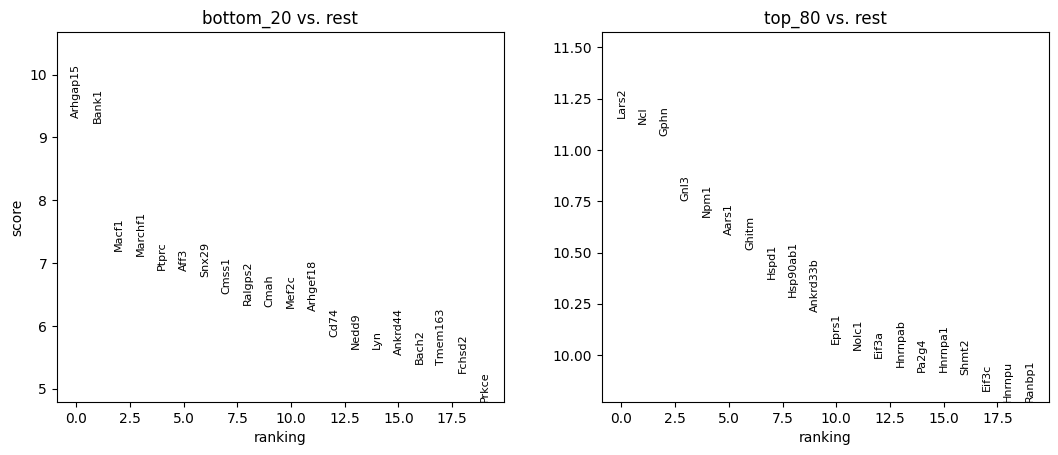


Top genes for 'top_80' group:


,gene,logfoldchanges,pvals_adj,scores
0,Lars2,3.502181,5.179375e-25,11.158943
1,Ncl,5.011395,5.179375e-25,11.127501
2,Gphn,2.916476,6.736222e-25,11.067760
3,Gnl3,6.734360,1.605686e-23,10.753335
4,Npm1,5.010652,3.003599e-23,10.674728
5,Aars1,6.004160,6.326563e-23,10.588262
6,Ghitm,5.368445,1.231075e-22,10.511228
7,Hspd1,4.853590,4.782234e-22,10.369736
8,Hsp90ab1,3.638165,1.029780e-21,10.284842
9,Ankrd33b,6.377811,1.958295e-21,10.212523



Top genes for 'bottom_20' group:


,gene,logfoldchanges,pvals_adj,scores
0,Arhgap15,2.301742,2.719150e-18,9.317985
1,Bank1,2.933892,5.433278e-18,9.229945
2,Macf1,1.893210,1.352629e-11,7.200332
3,Marchf1,5.995708,2.466666e-11,7.107577
4,Ptprc,1.729254,9.148980e-11,6.895340
5,Aff3,1.751268,1.075368e-10,6.870186
6,Snx29,3.835603,1.845066e-10,6.780575
7,Cmss1,0.982398,9.875640e-10,6.502309
8,Ralgps2,2.865114,2.655689e-09,6.330947
9,Cmah,4.062524,3.248659e-09,6.296360


In [153]:
# Use scanpy to compare gene expression between 'top_80' and 'bottom_20' groups

import scanpy as sc

# Get only the gene expression columns (exclude metadata columns)
gene_columns = [col for col in all_samples_with_expression.columns if col not in [
    'sample_id', 'true_label', 'probability', 'predicted_label', 'cyto_seed_score', 'group'
]]

# Filter the expression matrix to only include genes that are actually present in the data
expression_matrix = all_samples_with_expression[gene_columns]
print(f"Expression matrix shape: {expression_matrix.shape}")

# Create the AnnData object with the filtered expression data
# Use expression_matrix.columns as the index to ensure proper alignment
adata_compare = sc.AnnData(
    X=expression_matrix.values,
    obs=all_samples_with_expression[['sample_id', 'true_label', 'probability', 'predicted_label', 'cyto_seed_score', 'group']].copy(),
    var=pd.DataFrame(index=expression_matrix.columns, data={'gene_symbols': expression_matrix.columns})
)

print(f"AnnData shape: {adata_compare.shape}")
print(f"Var DataFrame shape: {adata_compare.var.shape}")
print(f"X shape: {adata_compare.X.shape}")

# Verify that var has the correct number of rows
assert adata_compare.var.shape[0] == adata_compare.X.shape[1], f"Var rows ({adata_compare.var.shape[0]}) must equal X columns ({adata_compare.X.shape[1]})"

# Run differential expression analysis using scanpy's rank_genes_groups
sc.tl.rank_genes_groups(
    adata_compare,
    groupby='group',
    method='wilcoxon',  # or 't-test', 'logreg', etc.
    pts=True
)

# Show summary of results
sc.pl.rank_genes_groups(adata_compare, n_genes=20, sharey=False)

# Get the results as a pandas DataFrame for further inspection
def get_rank_genes_df(adata, group):
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    df = pd.DataFrame({
        'gene': result['names'][group],
        'logfoldchanges': result['logfoldchanges'][group],
        'pvals_adj': result['pvals_adj'][group],
        'scores': result['scores'][group]
    })
    return df

print("\nTop genes for 'top_80' group:")
display(get_rank_genes_df(adata_compare, 'top_80').head(10))

print("\nTop genes for 'bottom_20' group:")
display(get_rank_genes_df(adata_compare, 'bottom_20').head(10))

Expression matrix shape: (169, 11237)
AnnData shape: (169, 11237)
Var DataFrame shape: (11237, 1)
X shape: (169, 11237)


/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning:

Transforming to str index.

/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning:

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.

/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning:

Variable names are not unique. To make them unique, call `.var_names_make_unique`.



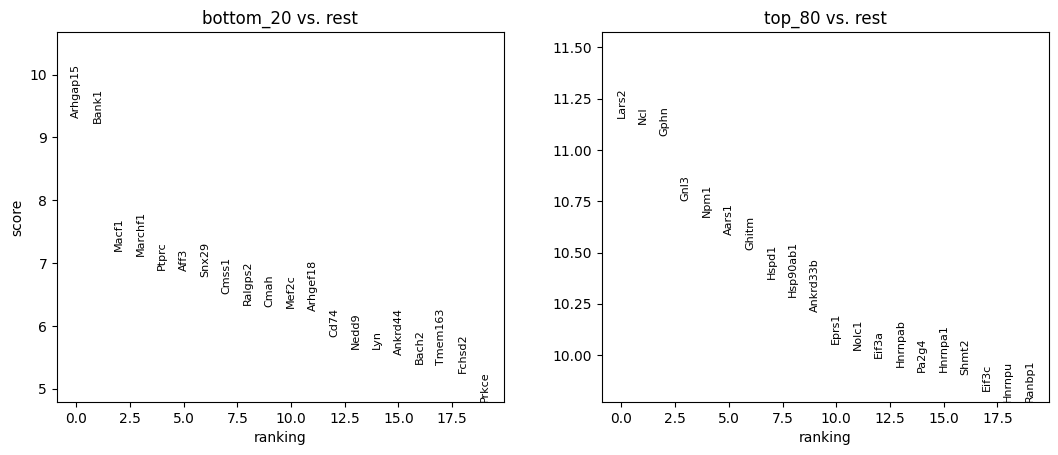


Top genes for 'top_80' group:


,gene,logfoldchanges,pvals_adj,scores
0,Lars2,3.502181,5.179375e-25,11.158943
1,Ncl,5.011395,5.179375e-25,11.127501
2,Gphn,2.916476,6.736222e-25,11.067760
3,Gnl3,6.734360,1.605686e-23,10.753335
4,Npm1,5.010652,3.003599e-23,10.674728
5,Aars1,6.004160,6.326563e-23,10.588262
6,Ghitm,5.368445,1.231075e-22,10.511228
7,Hspd1,4.853590,4.782234e-22,10.369736
8,Hsp90ab1,3.638165,1.029780e-21,10.284842
9,Ankrd33b,6.377811,1.958295e-21,10.212523



Top genes for 'bottom_20' group:


,gene,logfoldchanges,pvals_adj,scores
0,Arhgap15,2.301742,2.719150e-18,9.317985
1,Bank1,2.933892,5.433278e-18,9.229945
2,Macf1,1.893210,1.352629e-11,7.200332
3,Marchf1,5.995708,2.466666e-11,7.107577
4,Ptprc,1.729254,9.148980e-11,6.895340
5,Aff3,1.751268,1.075368e-10,6.870186
6,Snx29,3.835603,1.845066e-10,6.780575
7,Cmss1,0.982398,9.875640e-10,6.502309
8,Ralgps2,2.865114,2.655689e-09,6.330947
9,Cmah,4.062524,3.248659e-09,6.296360


In [156]:
# Use scanpy to compare gene expression between 'top_80' and 'bottom_20' groups

import scanpy as sc

# Get only the gene expression columns (exclude metadata columns)
gene_columns = [col for col in all_samples_with_expression.columns if col not in [
    'sample_id', 'true_label', 'probability', 'predicted_label', 'cyto_seed_score', 'group'
]]

# Filter the expression matrix to only include genes that are actually present in the data
expression_matrix = all_samples_with_expression[gene_columns]
print(f"Expression matrix shape: {expression_matrix.shape}")

# Create the AnnData object with the filtered expression data
# Use expression_matrix.columns as the index to ensure proper alignment
adata_compare = sc.AnnData(
    X=expression_matrix.values,
    obs=all_samples_with_expression[['sample_id', 'true_label', 'probability', 'predicted_label', 'cyto_seed_score', 'group']].copy(),
    var=pd.DataFrame(index=expression_matrix.columns, data={'gene_symbols': expression_matrix.columns})
)

print(f"AnnData shape: {adata_compare.shape}")
print(f"Var DataFrame shape: {adata_compare.var.shape}")
print(f"X shape: {adata_compare.X.shape}")

# Verify that var has the correct number of rows
assert adata_compare.var.shape[0] == adata_compare.X.shape[1], f"Var rows ({adata_compare.var.shape[0]}) must equal X columns ({adata_compare.X.shape[1]})"

# Run differential expression analysis using scanpy's rank_genes_groups
sc.tl.rank_genes_groups(
    adata_compare,
    groupby='group',
    method='wilcoxon',  # or 't-test', 'logreg', etc.
    pts=True
)

# Show summary of results
sc.pl.rank_genes_groups(adata_compare, n_genes=20, sharey=False)

# Get the results as a pandas DataFrame for further inspection
def get_rank_genes_df(adata, group):
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    df = pd.DataFrame({
        'gene': result['names'][group],
        'logfoldchanges': result['logfoldchanges'][group],
        'pvals_adj': result['pvals_adj'][group],
        'scores': result['scores'][group]
    })
    return df

print("\nTop genes for 'top_80' group:")
display(get_rank_genes_df(adata_compare, 'top_80').head(10))

print("\nTop genes for 'bottom_20' group:")
display(get_rank_genes_df(adata_compare, 'bottom_20').head(10))

=== Genes Upregulated and Downregulated with Probability ===


/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning:

invalid value encountered in divide



Total genes analyzed: 11190
Genes with positive correlation (upregulated with probability): 9003
Genes with negative correlation (downregulated with probability): 2187

TOP 20 GENES UPREGULATED WITH PROBABILITY
(Positive correlation - higher expression when probability increases)


,gene,correlation,abs_correlation
3532,Ncl,0.903599,0.903599
6382,Lars2,0.888006,0.888006
9364,Npm1,0.881511,0.881511
3438,Hspd1,0.837402,0.837402
2729,Hsp90ab1,0.833662,0.833662
7967,Gnl3,0.818872,0.818872
7381,Hnrnpu,0.818071,0.818071
3665,Eprs1,0.815526,0.815526
3251,Pa2g4,0.809045,0.809045
3121,Eif3a,0.803647,0.803647



TOP 20 GENES DOWNREGULATED WITH PROBABILITY
(Negative correlation - lower expression when probability increases)


,gene,correlation,abs_correlation
6947,Bank1,-0.655682,0.655682
10287,Snx29,-0.625785,0.625785
8706,Arhgap15,-0.624574,0.624574
6622,Marchf1,-0.618188,0.618188
1135,Cmah,-0.582933,0.582933
489,Arhgef18,-0.559294,0.559294
3655,Ralgps2,-0.537622,0.537622
8659,Sorl1,-0.509766,0.509766
588,Mef2c,-0.500178,0.500178
4411,Macf1,-0.493321,0.493321



VISUALIZATIONS

Box plots for top 10 upregulated genes:
Genes: ['Ncl', 'Lars2', 'Npm1', 'Hspd1', 'Hsp90ab1', 'Gnl3', 'Hnrnpu', 'Eprs1', 'Pa2g4', 'Eif3a']


/tmp/ipykernel_7713/3028330778.py:83: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/3028330778.py:83: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/3028330778.py:83: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/3028330778.py:83: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/3028330778.py:83: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; suppor

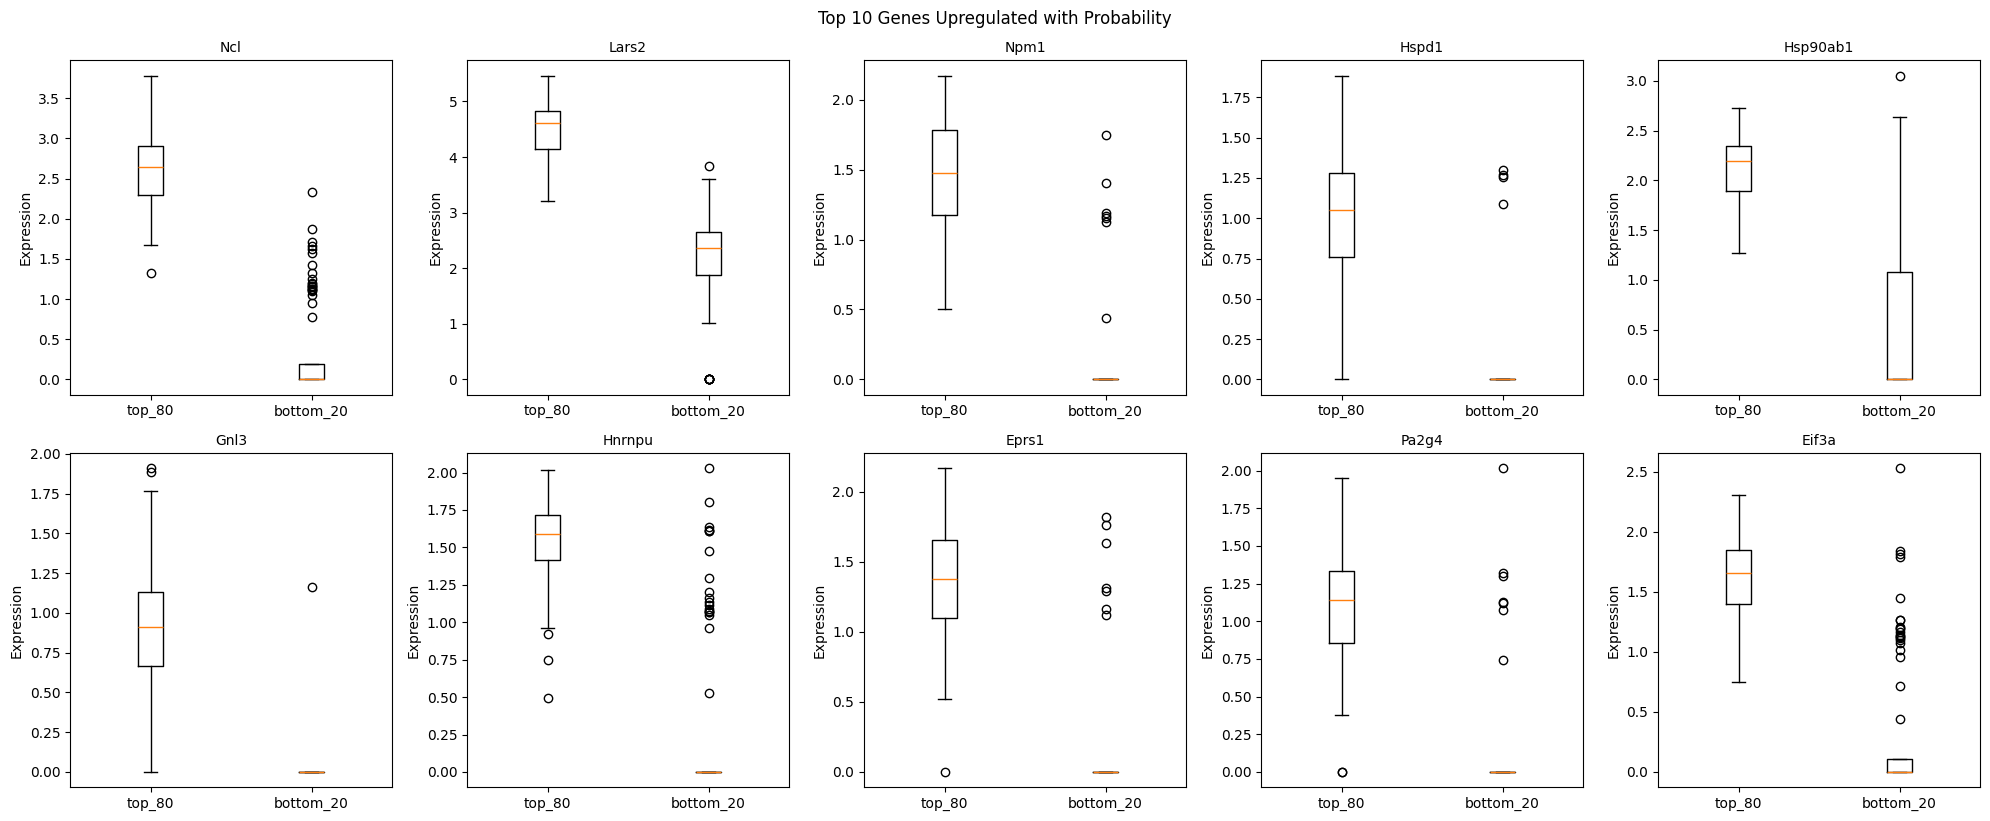


Box plots for top 10 downregulated genes:
Genes: ['Bank1', 'Snx29', 'Arhgap15', 'Marchf1', 'Cmah', 'Arhgef18', 'Ralgps2', 'Sorl1', 'Mef2c', 'Macf1']


/tmp/ipykernel_7713/3028330778.py:114: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/3028330778.py:114: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/3028330778.py:114: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/3028330778.py:114: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/3028330778.py:114: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; s

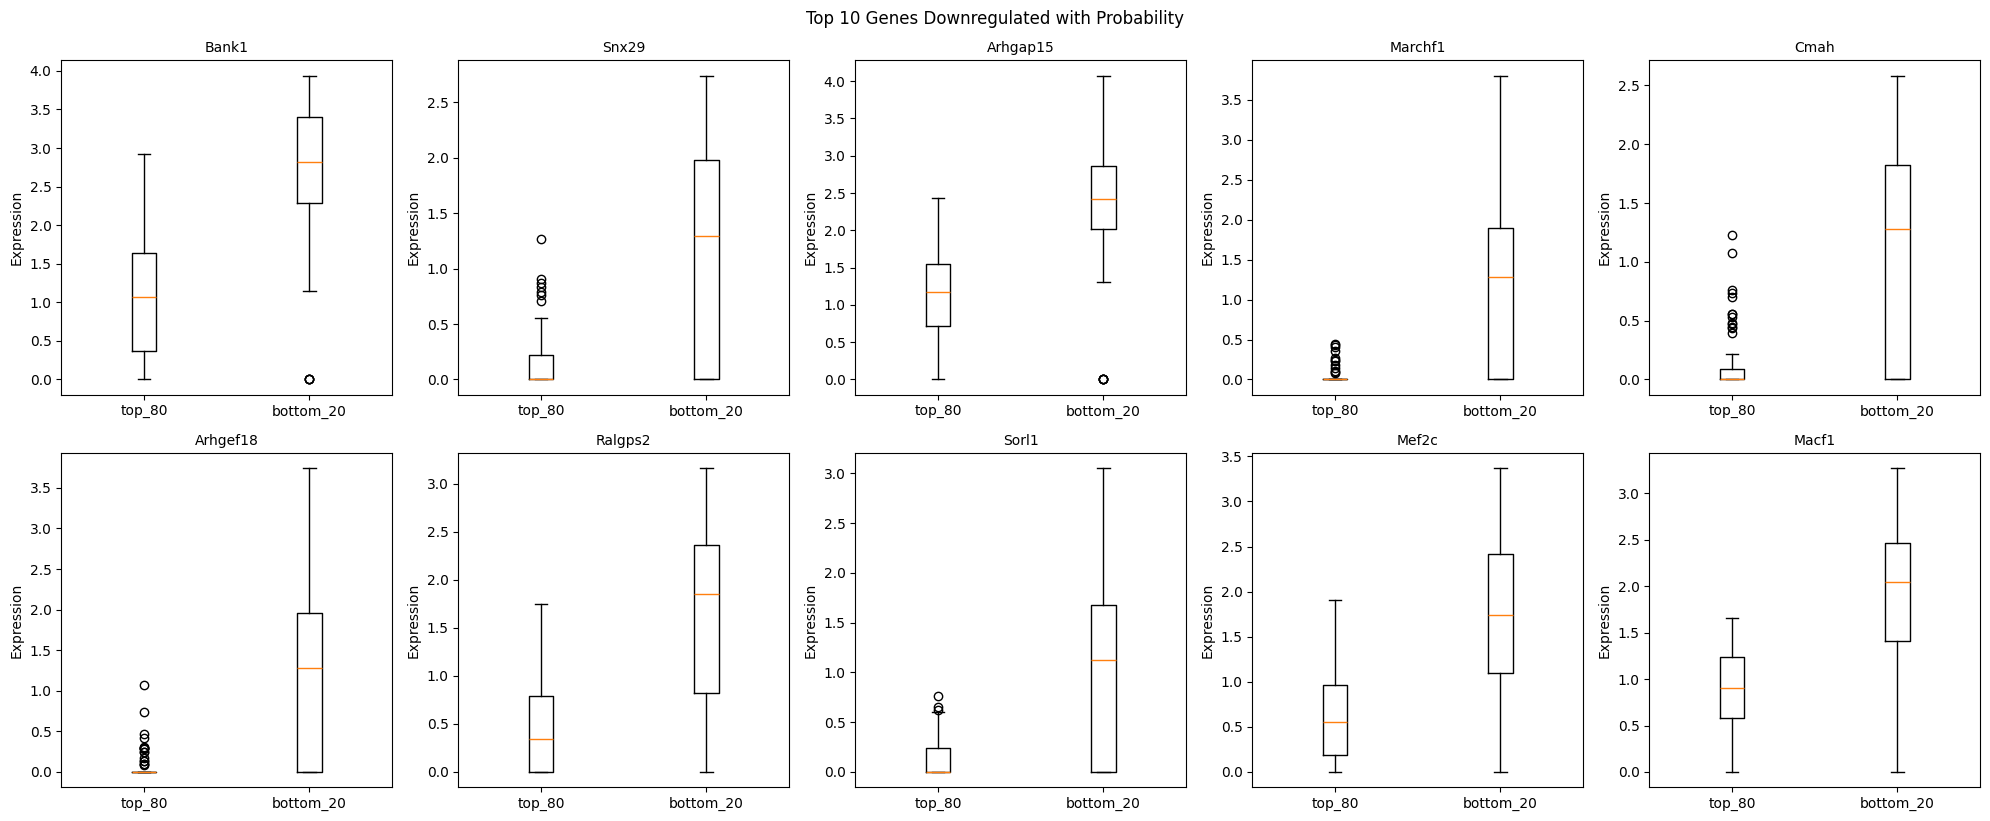


Heatmap of top genes (upregulated + downregulated):
Genes to plot: 30 out of 30


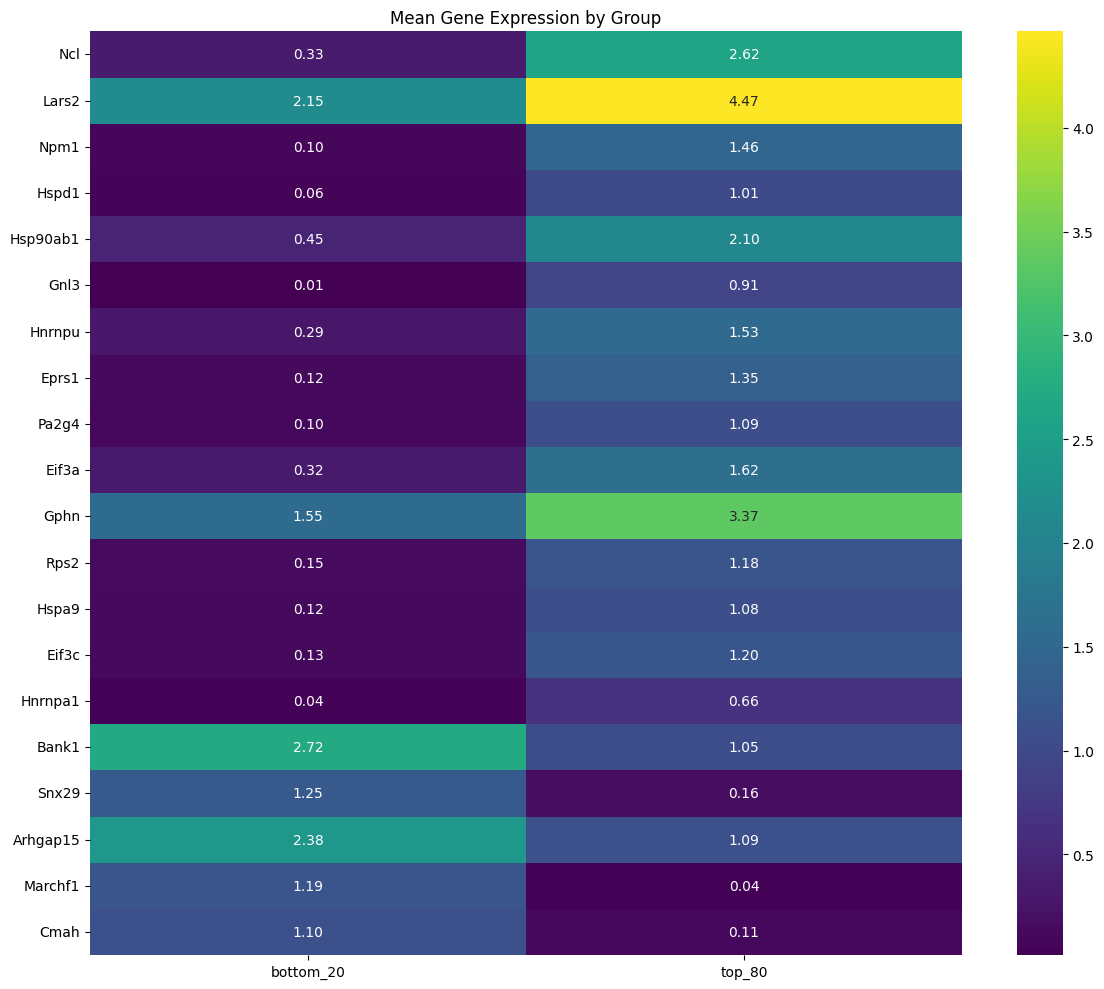


Correlation scatter plots for top 5 genes:


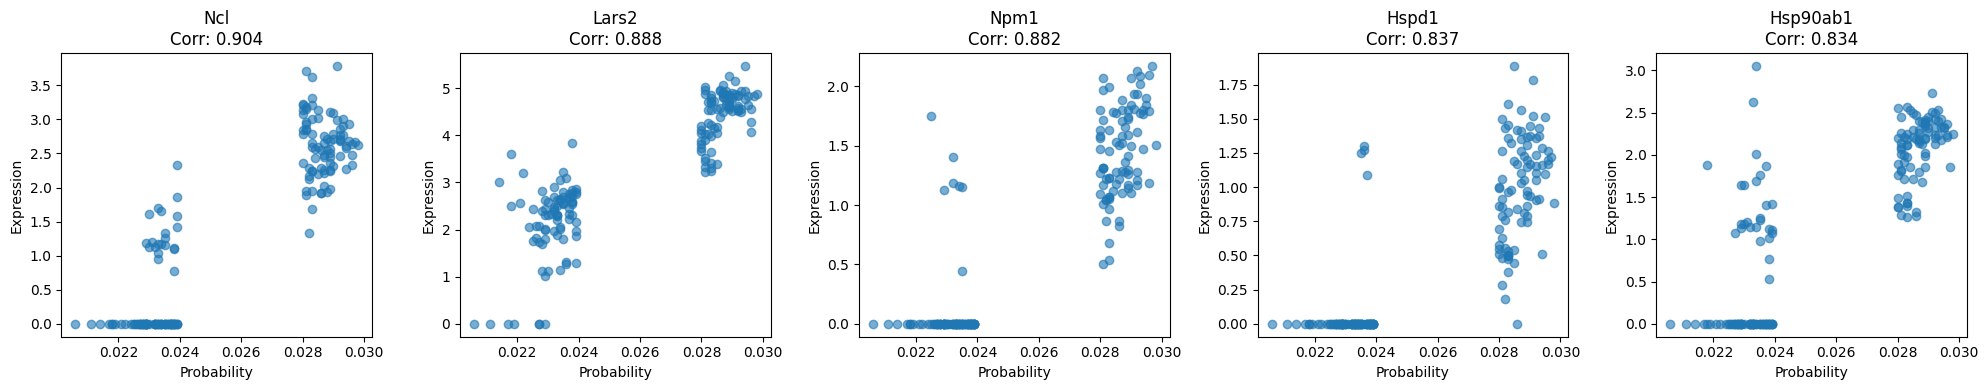


SAVING RESULTS
Saved upregulated genes to: genes_upregulated_with_probability.csv
Saved downregulated genes to: genes_downregulated_with_probability.csv
Saved all correlation results to: all_genes_probability_correlation.csv


In [159]:
# Analyze genes that change with probability - FIXED VERSION (no violin plot errors)
print("=== Genes Upregulated and Downregulated with Probability ===")

# Make observation and variable names unique first
adata_compare.obs_names_make_unique()
adata_compare.var_names_make_unique()

# Create a correlation analysis to find genes that change with probability
correlation_results = []
for gene in adata_compare.var_names:
    try:
        expression = adata_compare[:, gene].X.flatten()
        probability = adata_compare.obs['probability'].values
        
        # Remove any NaN values
        valid_mask = ~(np.isnan(expression) | np.isnan(probability))
        if np.sum(valid_mask) > 10:  # Need at least 10 valid points
            expression_clean = expression[valid_mask]
            probability_clean = probability[valid_mask]
            correlation = np.corrcoef(expression_clean, probability_clean)[0, 1]
            
            if not np.isnan(correlation):
                correlation_results.append({
                    'gene': gene,
                    'correlation': correlation,
                    'abs_correlation': abs(correlation)
                })
    except Exception as e:
        continue

correlation_df = pd.DataFrame(correlation_results)
if len(correlation_df) > 0:
    correlation_df = correlation_df.sort_values('abs_correlation', ascending=False)
    
    print(f"Total genes analyzed: {len(correlation_df)}")
    print(f"Genes with positive correlation (upregulated with probability): {len(correlation_df[correlation_df['correlation'] > 0])}")
    print(f"Genes with negative correlation (downregulated with probability): {len(correlation_df[correlation_df['correlation'] < 0])}")
    
    # Show top upregulated genes (positive correlation)
    print("\n" + "="*50)
    print("TOP 20 GENES UPREGULATED WITH PROBABILITY")
    print("(Positive correlation - higher expression when probability increases)")
    print("="*50)
    upregulated_genes = correlation_df[correlation_df['correlation'] > 0].head(20)
    display(upregulated_genes[['gene', 'correlation', 'abs_correlation']])
    
    # Show top downregulated genes (negative correlation)
    print("\n" + "="*50)
    print("TOP 20 GENES DOWNREGULATED WITH PROBABILITY")
    print("(Negative correlation - lower expression when probability increases)")
    print("="*50)
    downregulated_genes = correlation_df[correlation_df['correlation'] < 0].head(20)
    display(downregulated_genes[['gene', 'correlation', 'abs_correlation']])
    
    # Create visualizations - FIXED VERSION (no violin plot errors)
    print("\n" + "="*50)
    print("VISUALIZATIONS")
    print("="*50)
    
    # Top 10 upregulated genes - FIXED (using box plots instead of violin plots)
    top_up_genes = upregulated_genes.head(10)['gene'].tolist()
    print(f"\nBox plots for top 10 upregulated genes:")
    print(f"Genes: {top_up_genes}")
    
    # Filter genes that exist in the dataset
    existing_up_genes = [gene for gene in top_up_genes if gene in adata_compare.var_names]
    if existing_up_genes:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.flatten()
        
        for i, gene in enumerate(existing_up_genes[:10]):
            if i < len(axes):
                expression = adata_compare[:, gene].X.flatten()
                groups = adata_compare.obs['group'].values
                
                # Create box plot data
                top_80_data = expression[groups == 'top_80']
                bottom_20_data = expression[groups == 'bottom_20']
                
                axes[i].boxplot([top_80_data, bottom_20_data], labels=['top_80', 'bottom_20'])
                axes[i].set_title(gene, fontsize=10)
                axes[i].set_ylabel('Expression')
                
        plt.tight_layout()
        plt.suptitle('Top 10 Genes Upregulated with Probability', y=1.02)
        plt.show()
    
    # Top 10 downregulated genes - FIXED (using box plots instead of violin plots)
    top_down_genes = downregulated_genes.head(10)['gene'].tolist()
    print(f"\nBox plots for top 10 downregulated genes:")
    print(f"Genes: {top_down_genes}")
    
    # Filter genes that exist in the dataset
    existing_down_genes = [gene for gene in top_down_genes if gene in adata_compare.var_names]
    if existing_down_genes:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        axes = axes.flatten()
        
        for i, gene in enumerate(existing_down_genes[:10]):
            if i < len(axes):
                expression = adata_compare[:, gene].X.flatten()
                groups = adata_compare.obs['group'].values
                
                # Create box plot data
                top_80_data = expression[groups == 'top_80']
                bottom_20_data = expression[groups == 'bottom_20']
                
                axes[i].boxplot([top_80_data, bottom_20_data], labels=['top_80', 'bottom_20'])
                axes[i].set_title(gene, fontsize=10)
                axes[i].set_ylabel('Expression')
                
        plt.tight_layout()
        plt.suptitle('Top 10 Genes Downregulated with Probability', y=1.02)
        plt.show()
    
    # Heatmap - FIXED
    top_30_genes = upregulated_genes.head(15)['gene'].tolist() + downregulated_genes.head(15)['gene'].tolist()
    existing_30_genes = [gene for gene in top_30_genes if gene in adata_compare.var_names]
    print(f"\nHeatmap of top genes (upregulated + downregulated):")
    print(f"Genes to plot: {len(existing_30_genes)} out of {len(top_30_genes)}")
    
    if existing_30_genes:
        import seaborn as sns
        import matplotlib.pyplot as plt
        
        # Create a simple heatmap
        top_genes_data = adata_compare[:, existing_30_genes[:20]].X  # Limit to 20 genes
        groups = adata_compare.obs['group'].values
        
        # Calculate mean expression per group
        group_means = {}
        for group in np.unique(groups):
            group_mask = groups == group
            group_means[group] = np.mean(top_genes_data[group_mask], axis=0)
        
        heatmap_data = pd.DataFrame(group_means, index=existing_30_genes[:20])
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt='.2f')
        plt.title('Mean Gene Expression by Group')
        plt.tight_layout()
        plt.show()
    
    # Additional visualization: Correlation scatter plots for top genes
    print(f"\nCorrelation scatter plots for top 5 genes:")
    top_5_genes = correlation_df.head(5)['gene'].tolist()
    existing_top_5 = [gene for gene in top_5_genes if gene in adata_compare.var_names]
    
    if existing_top_5:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        if len(existing_top_5) == 1:
            axes = [axes]
        
        for i, gene in enumerate(existing_top_5):
            expression = adata_compare[:, gene].X.flatten()
            probability = adata_compare.obs['probability'].values
            
            axes[i].scatter(probability, expression, alpha=0.6)
            axes[i].set_xlabel('Probability')
            axes[i].set_ylabel('Expression')
            axes[i].set_title(f'{gene}\nCorr: {correlation_df[correlation_df["gene"]==gene]["correlation"].iloc[0]:.3f}')
            
        plt.tight_layout()
        plt.show()
    
    # Save results to CSV
    print("\n" + "="*50)
    print("SAVING RESULTS")
    print("="*50)
    
    # Save upregulated genes
    upregulated_genes.to_csv('genes_upregulated_with_probability.csv', index=False)
    print("Saved upregulated genes to: genes_upregulated_with_probability.csv")
    
    # Save downregulated genes
    downregulated_genes.to_csv('genes_downregulated_with_probability.csv', index=False)
    print("Saved downregulated genes to: genes_downregulated_with_probability.csv")
    
    # Save all correlation results
    correlation_df.to_csv('all_genes_probability_correlation.csv', index=False)
    print("Saved all correlation results to: all_genes_probability_correlation.csv")
    
else:
    print("No valid correlations found. Check your data for issues.")

=== Genes Upregulated and Downregulated with Probability ===


/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning:

invalid value encountered in divide

/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning:

invalid value encountered in divide



Total genes analyzed: 11190
Genes with positive correlation (upregulated): 9003
Genes with negative correlation (downregulated): 2187

=== Top 100 Upregulated Genes (Positively Correlated with Probability) ===

Gene names in order of highest to lowest correlation:
Ncl                 Mdn1                Kcnq5               Hspa5               Yars1               
Lars2               Gars1               Lars1               Abce1               Zc3h18              
Npm1                Rpl4                Txnrd1              Cbx5                Eif4g2              
Hspd1               Nolc1               Pdap1               Eif3j1              Eif4a1              
Hsp90ab1            Rpl6                Wdr75               Ide                 Ahctf1              
Gnl3                Aars1               Hk2                 Mphosph10           Bcat1               
Hnrnpu              Ddx21               Larp1               Impdh2              Slc7a5              
Eprs1               Serbp1  

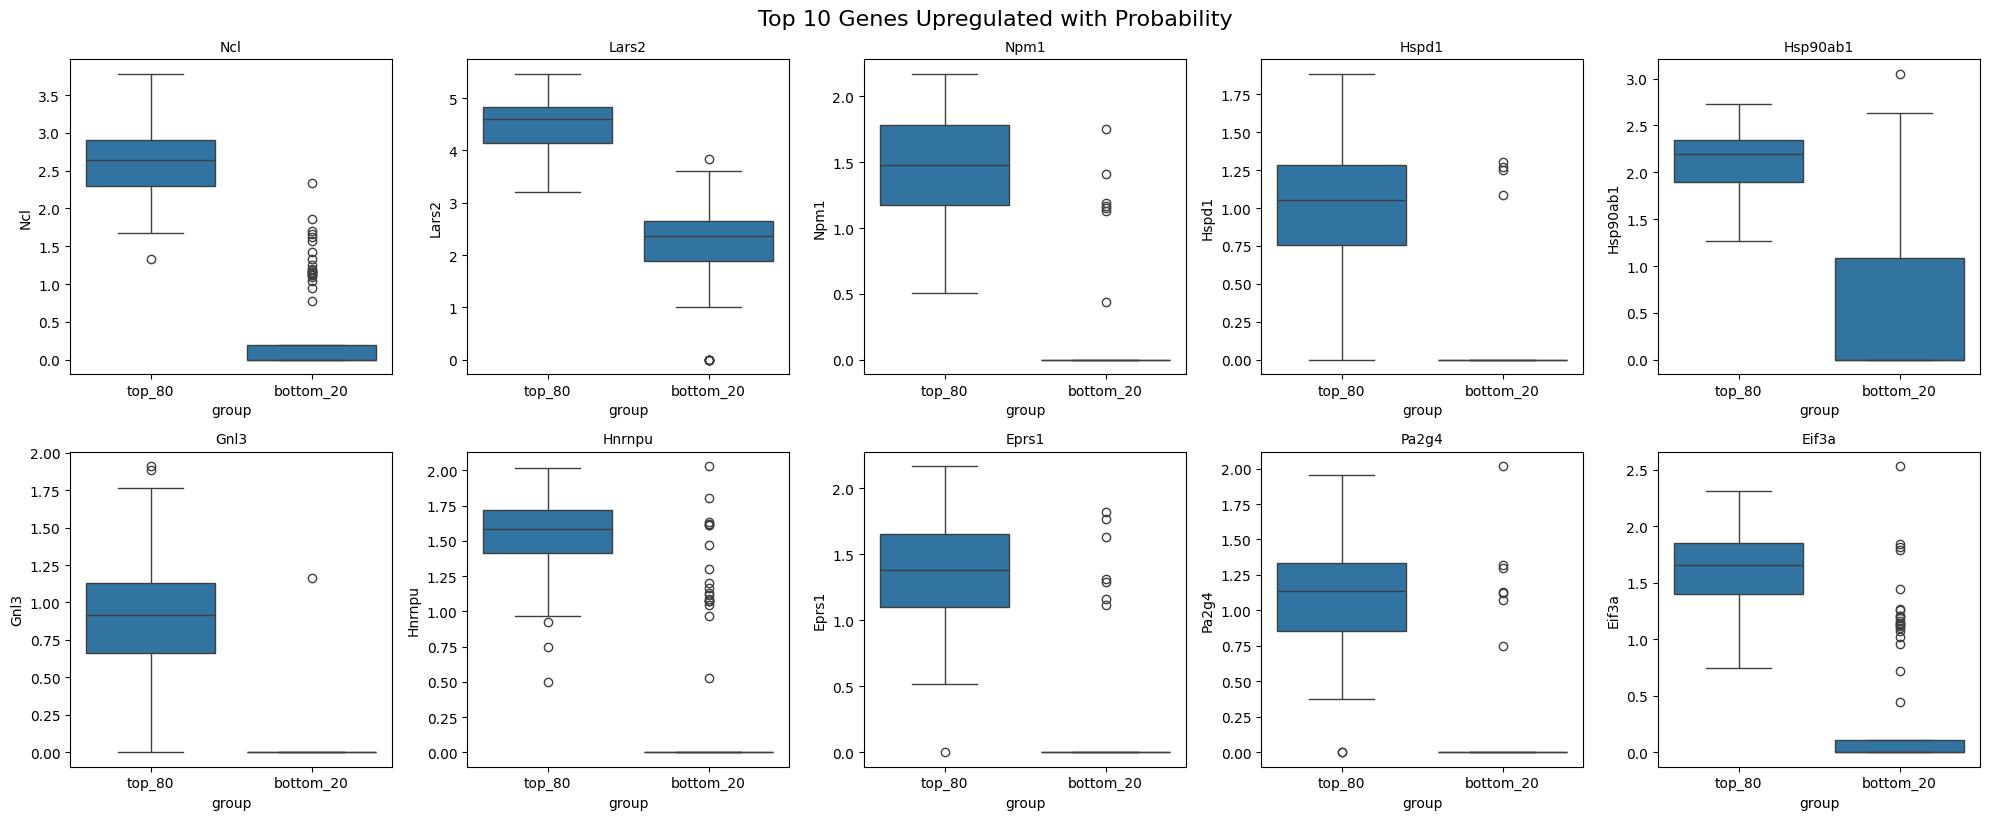


Box plots for top 10 downregulated genes:


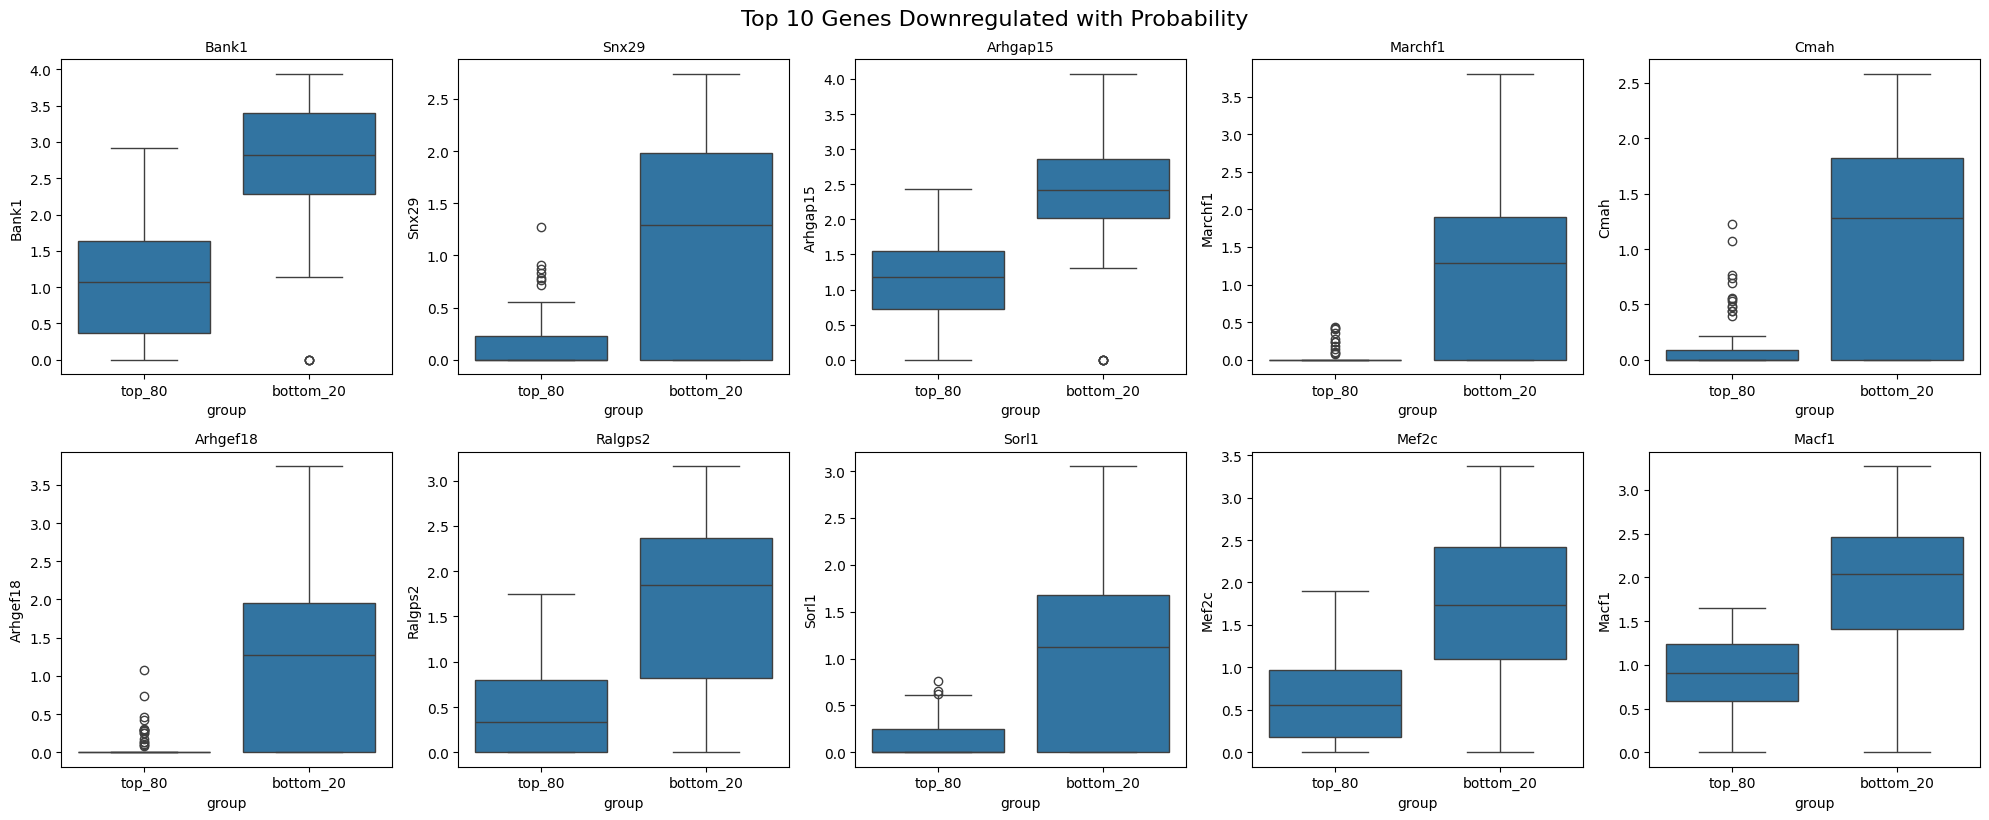


SAVING RESULTS
Saved all upregulated genes to: genes_upregulated_with_probability.csv
Saved all downregulated genes to: genes_downregulated_with_probability.csv


In [169]:
# Analyze genes that change with probability - FULLY CORRECTED
print("=== Genes Upregulated and Downregulated with Probability ===")

# Make observation and variable names unique first
if 'rank_genes_groups' in adata_compare.uns:
    del adata_compare.uns['rank_genes_groups'] # remove old results
adata_compare.obs_names_make_unique()
adata_compare.var_names_make_unique()


# Create a correlation analysis to find genes that change with probability
correlation_results = []
for gene in adata_compare.var_names:
    try:
        expression = adata_compare[:, gene].X.flatten()
        probability = adata_compare.obs['probability'].values
        
        # Remove any NaN values
        valid_mask = ~(np.isnan(expression) | np.isnan(probability))
        if np.sum(valid_mask) > 10:
            expression_clean = expression[valid_mask]
            probability_clean = probability[valid_mask]
            correlation = np.corrcoef(expression_clean, probability_clean)[0, 1]
            
            if not np.isnan(correlation):
                correlation_results.append({
                    'gene': gene,
                    'correlation': correlation
                })
    except Exception as e:
        continue

correlation_df = pd.DataFrame(correlation_results)
if len(correlation_df) > 0:
    correlation_df = correlation_df.sort_values('correlation', ascending=False)
    
    # Get the complete lists of all upregulated and downregulated genes
    upregulated_genes = correlation_df[correlation_df['correlation'] > 0]
    downregulated_genes = correlation_df[correlation_df['correlation'] < 0]
    
    print(f"Total genes analyzed: {len(correlation_df)}")
    print(f"Genes with positive correlation (upregulated): {len(upregulated_genes)}")
    print(f"Genes with negative correlation (downregulated): {len(downregulated_genes)}")
    
    # --- DISPLAY TOP 100 UPREGULATED GENES ---
    print("\n" + "="*100)
    print("=== Top 100 Upregulated Genes (Positively Correlated with Probability) ===")
    
    top_100_upregulated = upregulated_genes.head(100)
    
    print("\nGene names in order of highest to lowest correlation:")
    print("="*100)
    
    num_columns = 5
    genes_per_column = 20
    column_width = 20
    
    # Print genes in 5 columns
    for row in range(genes_per_column):
        formatted_row = []
        for col in range(num_columns):
            gene_index = row + (col * genes_per_column)
            if gene_index < len(top_100_upregulated):
                gene_name = top_100_upregulated['gene'].iloc[gene_index]
                formatted_gene = gene_name.ljust(column_width)[:column_width]
            else:
                formatted_gene = ''.ljust(column_width)
            formatted_row.append(formatted_gene)
        print(''.join(formatted_row))
    
    print("\n" + "="*100)

    # --- DISPLAY TOP 100 DOWNREGULATED GENES ---
    print("\n" + "="*100)
    print("=== Top 100 Downregulated Genes (Negatively Correlated with Probability) ===")

    # For downregulated, we sort by correlation ascending to get the most negative first
    top_100_downregulated = downregulated_genes.sort_values('correlation', ascending=True).head(100)

    print("\nGene names in order of highest to lowest correlation (most negative first):")
    print("="*100)

    for row in range(genes_per_column):
        formatted_row = []
        for col in range(num_columns):
            gene_index = row + (col * genes_per_column)
            if gene_index < len(top_100_downregulated):
                gene_name = top_100_downregulated['gene'].iloc[gene_index]
                formatted_gene = gene_name.ljust(column_width)[:column_width]
            else:
                formatted_gene = ''.ljust(column_width)
            formatted_row.append(formatted_gene)
        print(''.join(formatted_row))

    print("\n" + "="*100)

    # --- VISUALIZATIONS ---
    print("\nVISUALIZATIONS")
    print("="*50)
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Get gene expression for all samples from the dataframe created earlier
    expression_df_vis = all_samples_with_expression.copy()
    
    # Top 10 Upregulated Genes - Box plots
    top_up_genes = top_100_upregulated.head(10)['gene'].tolist()
    print(f"\nBox plots for top 10 upregulated genes:")
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    for i, gene in enumerate(top_up_genes):
        if gene in expression_df_vis.columns:
             sns.boxplot(x='group', y=gene, data=expression_df_vis, ax=axes[i])
             axes[i].set_title(gene, fontsize=10)
    plt.tight_layout()
    plt.suptitle('Top 10 Genes Upregulated with Probability', y=1.02, fontsize=16)
    plt.show()

    # Top 10 Downregulated Genes - Box plots
    top_down_genes = top_100_downregulated.head(10)['gene'].tolist()
    print(f"\nBox plots for top 10 downregulated genes:")
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    for i, gene in enumerate(top_down_genes):
        if gene in expression_df_vis.columns:
            sns.boxplot(x='group', y=gene, data=expression_df_vis, ax=axes[i])
            axes[i].set_title(gene, fontsize=10)
    plt.tight_layout()
    plt.suptitle('Top 10 Genes Downregulated with Probability', y=1.02, fontsize=16)
    plt.show()

    # --- SAVE RESULTS ---
    print("\nSAVING RESULTS")
    print("="*50)
    upregulated_genes.to_csv('genes_upregulated_with_probability.csv', index=False)
    print("Saved all upregulated genes to: genes_upregulated_with_probability.csv")
    downregulated_genes.to_csv('genes_downregulated_with_probability.csv', index=False)
    print("Saved all downregulated genes to: genes_downregulated_with_probability.csv")

else:
    print("No valid correlations found. Check your data for issues.")

In [ ]:
ajm_cyto_filtered.obs['sample_id']

Series([], Name: sample_id, dtype: category
Categories (0, object): [])

=== Analyzing Multimodal Distribution in True 0's ===
Total samples with true_label = 0: 313


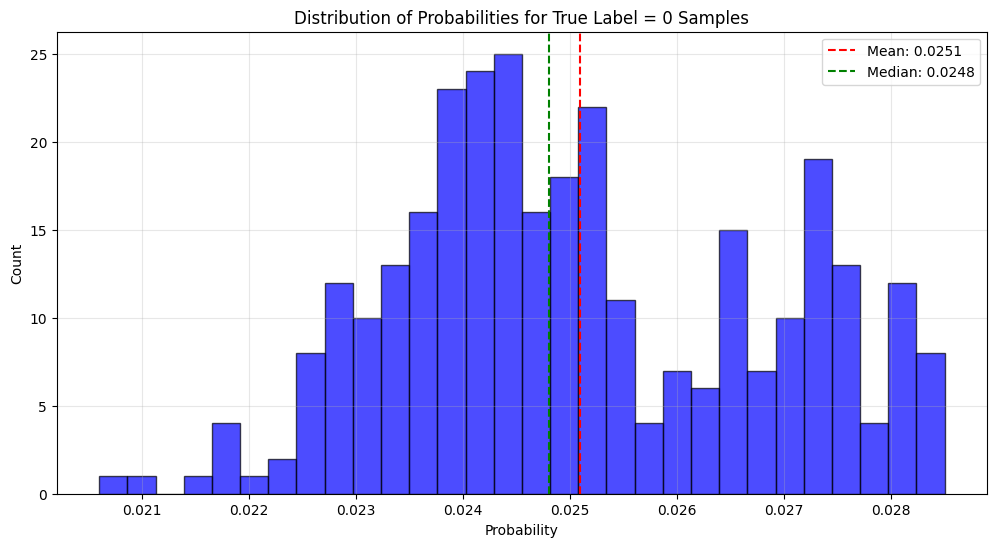


=== Cluster Analysis for True 0's ===

Cluster 0:
  Number of samples: 84
  Mean probability: 0.0231
  Std probability: 0.0007
  Min probability: 0.0206
  Max probability: 0.0239

Cluster 1:
  Number of samples: 95
  Mean probability: 0.0273
  Std probability: 0.0006
  Min probability: 0.0261
  Max probability: 0.0285

Cluster 2:
  Number of samples: 134
  Mean probability: 0.0248
  Std probability: 0.0006
  Min probability: 0.0240
  Max probability: 0.0260


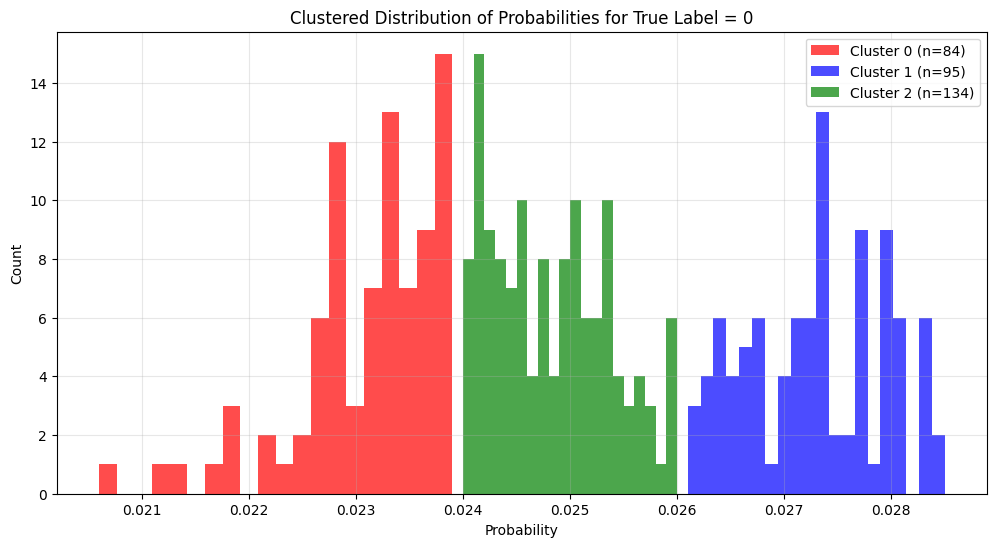


=== Extracting Gene Expression Data for Each Cluster ===
cluster_0: (84, 10891)
cluster_1: (95, 10891)
cluster_2: (134, 10891)

=== Combining Clusters for Analysis ===
Combined clusters shape: (313, 10891)

=== Converting to Gene Symbols ===


/tmp/ipykernel_7713/3347928156.py:80: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/tmp/ipykernel_7713/3347928156.py:80: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/tmp/ipykernel_7713/3347928156.py:80: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
10887 input query terms found no hit:	['Gnai3', 'Cdc45', 'Narf', 'Klf6', 'Scmh1', 'Cox5a', 'Fer', 'Xpo6', 'Tfe3', 'Brat1', 'Gna12', 'Dlat'


KeyError: 'symbol'

In [171]:

# Analyze multimodal distribution in true 0's - FIXED VERSION
print("=== Analyzing Multimodal Distribution in True 0's ===")

# Get all samples with true_label = 0
true_0_samples = best_test_stats[best_test_stats['true_label'] == 0].copy()
print(f"Total samples with true_label = 0: {len(true_0_samples)}")

# Plot the distribution to see the modes
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

plt.figure(figsize=(12, 6))
plt.hist(true_0_samples['probability'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Distribution of Probabilities for True Label = 0 Samples')
plt.axvline(true_0_samples['probability'].mean(), color='red', linestyle='--', label=f'Mean: {true_0_samples["probability"].mean():.4f}')
plt.axvline(true_0_samples['probability'].median(), color='green', linestyle='--', label=f'Median: {true_0_samples["probability"].median():.4f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Cluster the true 0 samples into 3 groups
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare data for clustering
probabilities = true_0_samples['probability'].values.reshape(-1, 1)
scaler = StandardScaler()
probabilities_scaled = scaler.fit_transform(probabilities)

# Use 3 clusters as requested
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
true_0_samples['cluster'] = kmeans.fit_predict(probabilities_scaled)

# Analyze each cluster
print(f"\n=== Cluster Analysis for True 0's ===")
cluster_sample_ids = {}
for cluster_id in range(3):
    cluster_samples = true_0_samples[true_0_samples['cluster'] == cluster_id]
    cluster_sample_ids[f'cluster_{cluster_id}'] = cluster_samples['sample_id'].tolist()
    
    print(f"\nCluster {cluster_id}:")
    print(f"  Number of samples: {len(cluster_samples)}")
    print(f"  Mean probability: {cluster_samples['probability'].mean():.4f}")
    print(f"  Std probability: {cluster_samples['probability'].std():.4f}")
    print(f"  Min probability: {cluster_samples['probability'].min():.4f}")
    print(f"  Max probability: {cluster_samples['probability'].max():.4f}")

# Visualize the clusters
plt.figure(figsize=(12, 6))
colors = ['red', 'blue', 'green']
for cluster_id in range(3):
    cluster_samples = true_0_samples[true_0_samples['cluster'] == cluster_id]
    plt.hist(cluster_samples['probability'], bins=20, alpha=0.7, 
             label=f'Cluster {cluster_id} (n={len(cluster_samples)})', 
             color=colors[cluster_id])

plt.xlabel('Probability')
plt.ylabel('Count')
plt.title('Clustered Distribution of Probabilities for True Label = 0')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Extract gene expression data for each cluster
print(f"\n=== Extracting Gene Expression Data for Each Cluster ===")
cluster_expression_data = {}
for cluster_name, sample_ids in cluster_sample_ids.items():
    # Get the AnnData subset for this cluster
    cluster_adata = ajm_cyto_filtered[ajm_cyto_filtered.obs['sample_id'].isin(sample_ids)]
    cluster_expression_data[cluster_name] = cluster_adata
    print(f"{cluster_name}: {cluster_adata.shape}")

# Combine all cluster data into one AnnData object for comparison
print(f"\n=== Combining Clusters for Analysis ===")
all_cluster_samples = []
for cluster_name, adata in cluster_expression_data.items():
    adata.obs['cluster_group'] = cluster_name
    all_cluster_samples.append(adata)

# Concatenate all clusters
combined_clusters = ad.concat(all_cluster_samples, join='outer')
print(f"Combined clusters shape: {combined_clusters.shape}")

# Make sure we have gene symbols instead of Ensembl IDs
print(f"\n=== Converting to Gene Symbols ===")
if 'gene_symbols' in combined_clusters.var:
    # Use existing gene symbols
    combined_clusters.var_names = combined_clusters.var['gene_symbols']
    print("Using existing gene symbols")
else:
    # Convert Ensembl IDs to gene symbols
    import mygene
    mg = mygene.MyGeneInfo()
    
    # Get gene symbols for all genes
    gene_info = mg.querymany(combined_clusters.var_names, scopes='ensembl.gene', fields='symbol', species='mouse', as_dataframe=True)
    
    # Create mapping from Ensembl ID to gene symbol
    ensembl_to_symbol = gene_info['symbol'].to_dict()
    
    # Update gene names
    new_gene_names = []
    for ensembl_id in combined_clusters.var_names:
        symbol = ensembl_to_symbol.get(ensembl_id, ensembl_id)
        new_gene_names.append(symbol)
    
    combined_clusters.var_names = new_gene_names
    print("Converted Ensembl IDs to gene symbols")

# Make names unique
combined_clusters.var_names_make_unique()
combined_clusters.obs_names_make_unique()

print(f"Final combined clusters shape: {combined_clusters.shape}")
print(f"Sample gene names: {combined_clusters.var_names[:10].tolist()}")

# Run differential expression analysis between clusters
print(f"\n=== Running Differential Expression Analysis ===")
sc.tl.rank_genes_groups(
    combined_clusters,
    groupby='cluster_group',
    method='wilcoxon',
    pts=True
)

# Function to get results as DataFrame
def get_rank_genes_df(adata, group):
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    df = pd.DataFrame({
        'gene': result['names'][group],
        'logfoldchanges': result['logfoldchanges'][group],
        'pvals_adj': result['pvals_adj'][group],
        'scores': result['scores'][group]
    })
    return df

# Show results for each cluster comparison
print(f"\n=== Top Genes for Each Cluster ===")
for cluster_name in cluster_sample_ids.keys():
    print(f"\n--- Top 20 genes for {cluster_name} ---")
    try:
        result_df = get_rank_genes_df(combined_clusters, cluster_name)
        # Filter for significant genes (p < 0.05)
        significant_genes = result_df[result_df['pvals_adj'] < 0.05]
        print(f"Significant genes (p < 0.05): {len(significant_genes)}")
        display(significant_genes.head(20))
        
        # Save results for this cluster
        significant_genes.to_csv(f'{cluster_name}_top_genes.csv', index=False)
        print(f"Saved {cluster_name} results to: {cluster_name}_top_genes.csv")
        
    except Exception as e:
        print(f"Error getting results for {cluster_name}: {e}")

# Create heatmap of top genes
print(f"\n=== Creating Heatmap of Top Genes ===")
try:
    # Get top genes from all clusters
    all_top_genes = []
    for cluster_name in cluster_sample_ids.keys():
        try:
            result_df = get_rank_genes_df(combined_clusters, cluster_name)
            # Get top 10 significant genes
            significant_genes = result_df[result_df['pvals_adj'] < 0.05]
            top_genes = significant_genes.head(10)['gene'].tolist()
            all_top_genes.extend(top_genes)
        except:
            continue
    
    # Remove duplicates and limit to existing genes
    unique_top_genes = list(set(all_top_genes))
    existing_genes = [gene for gene in unique_top_genes if gene in combined_clusters.var_names]
    
    print(f"Total unique top genes: {len(existing_genes)}")
    
    if existing_genes:
        # Create heatmap
        sc.pl.heatmap(combined_clusters, 
                      var_names=existing_genes[:50],  # Limit to 50 genes
                      groupby='cluster_group',
                      use_raw=False,
                      show_gene_labels=True,
                      figsize=(20, 15),
                      title='Top Genes Between Clusters')
        
        # Also create violin plots for top genes
        print(f"\n=== Creating Violin Plots for Top Genes ===")
        top_10_genes = existing_genes[:10]
        sc.pl.violin(combined_clusters, 
                     keys=top_10_genes, 
                     groupby='cluster_group',
                     use_raw=False,
                     figsize=(20, 10),
                     title='Top 10 Genes Expression by Cluster')
        
except Exception as e:
    print(f"Error creating visualizations: {e}")

# Save cluster assignments
true_0_samples.to_csv('true_0_clusters.csv', index=False)
print(f"\nSaved cluster assignments to: true_0_clusters.csv")

# Summary statistics
print(f"\n=== Summary ===")
print(f"Total true 0 samples analyzed: {len(true_0_samples)}")
print(f"Clusters created: {len(cluster_sample_ids)}")
for cluster_name, sample_ids in cluster_sample_ids.items():
    print(f"  {cluster_name}: {len(sample_ids)} samples")

In [172]:
# Extract sample IDs for each cluster and get their gene expression
print("=== Extracting Gene Expression by Cluster ===")

# Get the gene expression matrix with symbol names
# Assuming we have the combined_clusters AnnData object with gene symbols
gene_expr_matrix = combined_clusters.to_df()

# Create a dictionary to store gene expression for each cluster
cluster_gene_expression = {}

for cluster_name, sample_ids in cluster_sample_ids.items():
    print(f"\nProcessing cluster: {cluster_name}")
    print(f"Number of samples in cluster: {len(sample_ids)}")
    
    # Get the gene expression for samples in this cluster
    cluster_samples = [sample for sample in sample_ids if sample in gene_expr_matrix.index]
    
    if cluster_samples:
        # Extract gene expression for this cluster
        cluster_expr = gene_expr_matrix.loc[cluster_samples]
        
        # Add cluster name as a prefix to sample IDs for identification
        cluster_expr.index = [f"{cluster_name}_{sample}" for sample in cluster_expr.index]
        
        # Store in dictionary
        cluster_gene_expression[cluster_name] = cluster_expr
        
        print(f"Extracted expression for {len(cluster_samples)} samples")
        print(f"Expression matrix shape: {cluster_expr.shape}")
        
        # Save individual cluster expression to CSV
        output_filename = f"cluster_{cluster_name}_gene_expression.csv"
        cluster_expr.to_csv(output_filename)
        print(f"Saved to: {output_filename}")
    else:
        print(f"No samples found in gene expression matrix for cluster {cluster_name}")

# Combine all clusters into one matrix with cluster labels
if cluster_gene_expression:
    print(f"\n=== Combining All Clusters ===")
    
    # Combine all cluster expression matrices
    all_cluster_expr = pd.concat(cluster_gene_expression.values(), axis=0)
    
    # Create cluster labels
    cluster_labels = []
    for cluster_name, expr_matrix in cluster_gene_expression.items():
        cluster_labels.extend([cluster_name] * len(expr_matrix))
    
    # Add cluster labels as a column
    all_cluster_expr['cluster'] = cluster_labels
    
    # Save combined expression matrix
    all_cluster_expr.to_csv('all_clusters_gene_expression.csv')
    print(f"Combined expression matrix shape: {all_cluster_expr.shape}")
    print(f"Saved combined expression to: all_clusters_gene_expression.csv")
    
    # Display summary
    print(f"\n=== Cluster Summary ===")
    for cluster_name, expr_matrix in cluster_gene_expression.items():
        print(f"{cluster_name}: {len(expr_matrix)} samples, {expr_matrix.shape[1]} genes")
    
    # Show first few rows of combined matrix
    print(f"\n=== First few rows of combined expression matrix ===")
    print(all_cluster_expr.head())
    
else:
    print("No cluster gene expression data to process")


=== Extracting Gene Expression by Cluster ===

Processing cluster: cluster_0
Number of samples in cluster: 84
Extracted expression for 84 samples
Expression matrix shape: (84, 10891)
Saved to: cluster_cluster_0_gene_expression.csv

Processing cluster: cluster_1
Number of samples in cluster: 95
Extracted expression for 95 samples
Expression matrix shape: (95, 10891)
Saved to: cluster_cluster_1_gene_expression.csv

Processing cluster: cluster_2
Number of samples in cluster: 134
Extracted expression for 134 samples
Expression matrix shape: (134, 10891)
Saved to: cluster_cluster_2_gene_expression.csv

=== Combining All Clusters ===
Combined expression matrix shape: (313, 10892)
Saved combined expression to: all_clusters_gene_expression.csv

=== Cluster Summary ===
cluster_0: 84 samples, 10891 genes
cluster_1: 95 samples, 10891 genes
cluster_2: 134 samples, 10891 genes

=== First few rows of combined expression matrix ===
                              Gnai3  Cdc45      Narf  Klf6  Scmh1  Co

=== Gene Expression Analysis Between Clusters ===

=== Differential Gene Expression Analysis ===
Clusters to compare: ['cluster_0' 'cluster_1' 'cluster_2']

=== One-vs-Rest Analysis for Each Cluster ===

=== Creating Box Plots for Top Genes ===
Total unique upregulated genes: 29
Total unique downregulated genes: 29

--- Box Plots for Upregulated Genes ---


/tmp/ipykernel_7713/1015343757.py:92: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/1015343757.py:92: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/1015343757.py:92: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/1015343757.py:92: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/1015343757.py:92: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; suppor

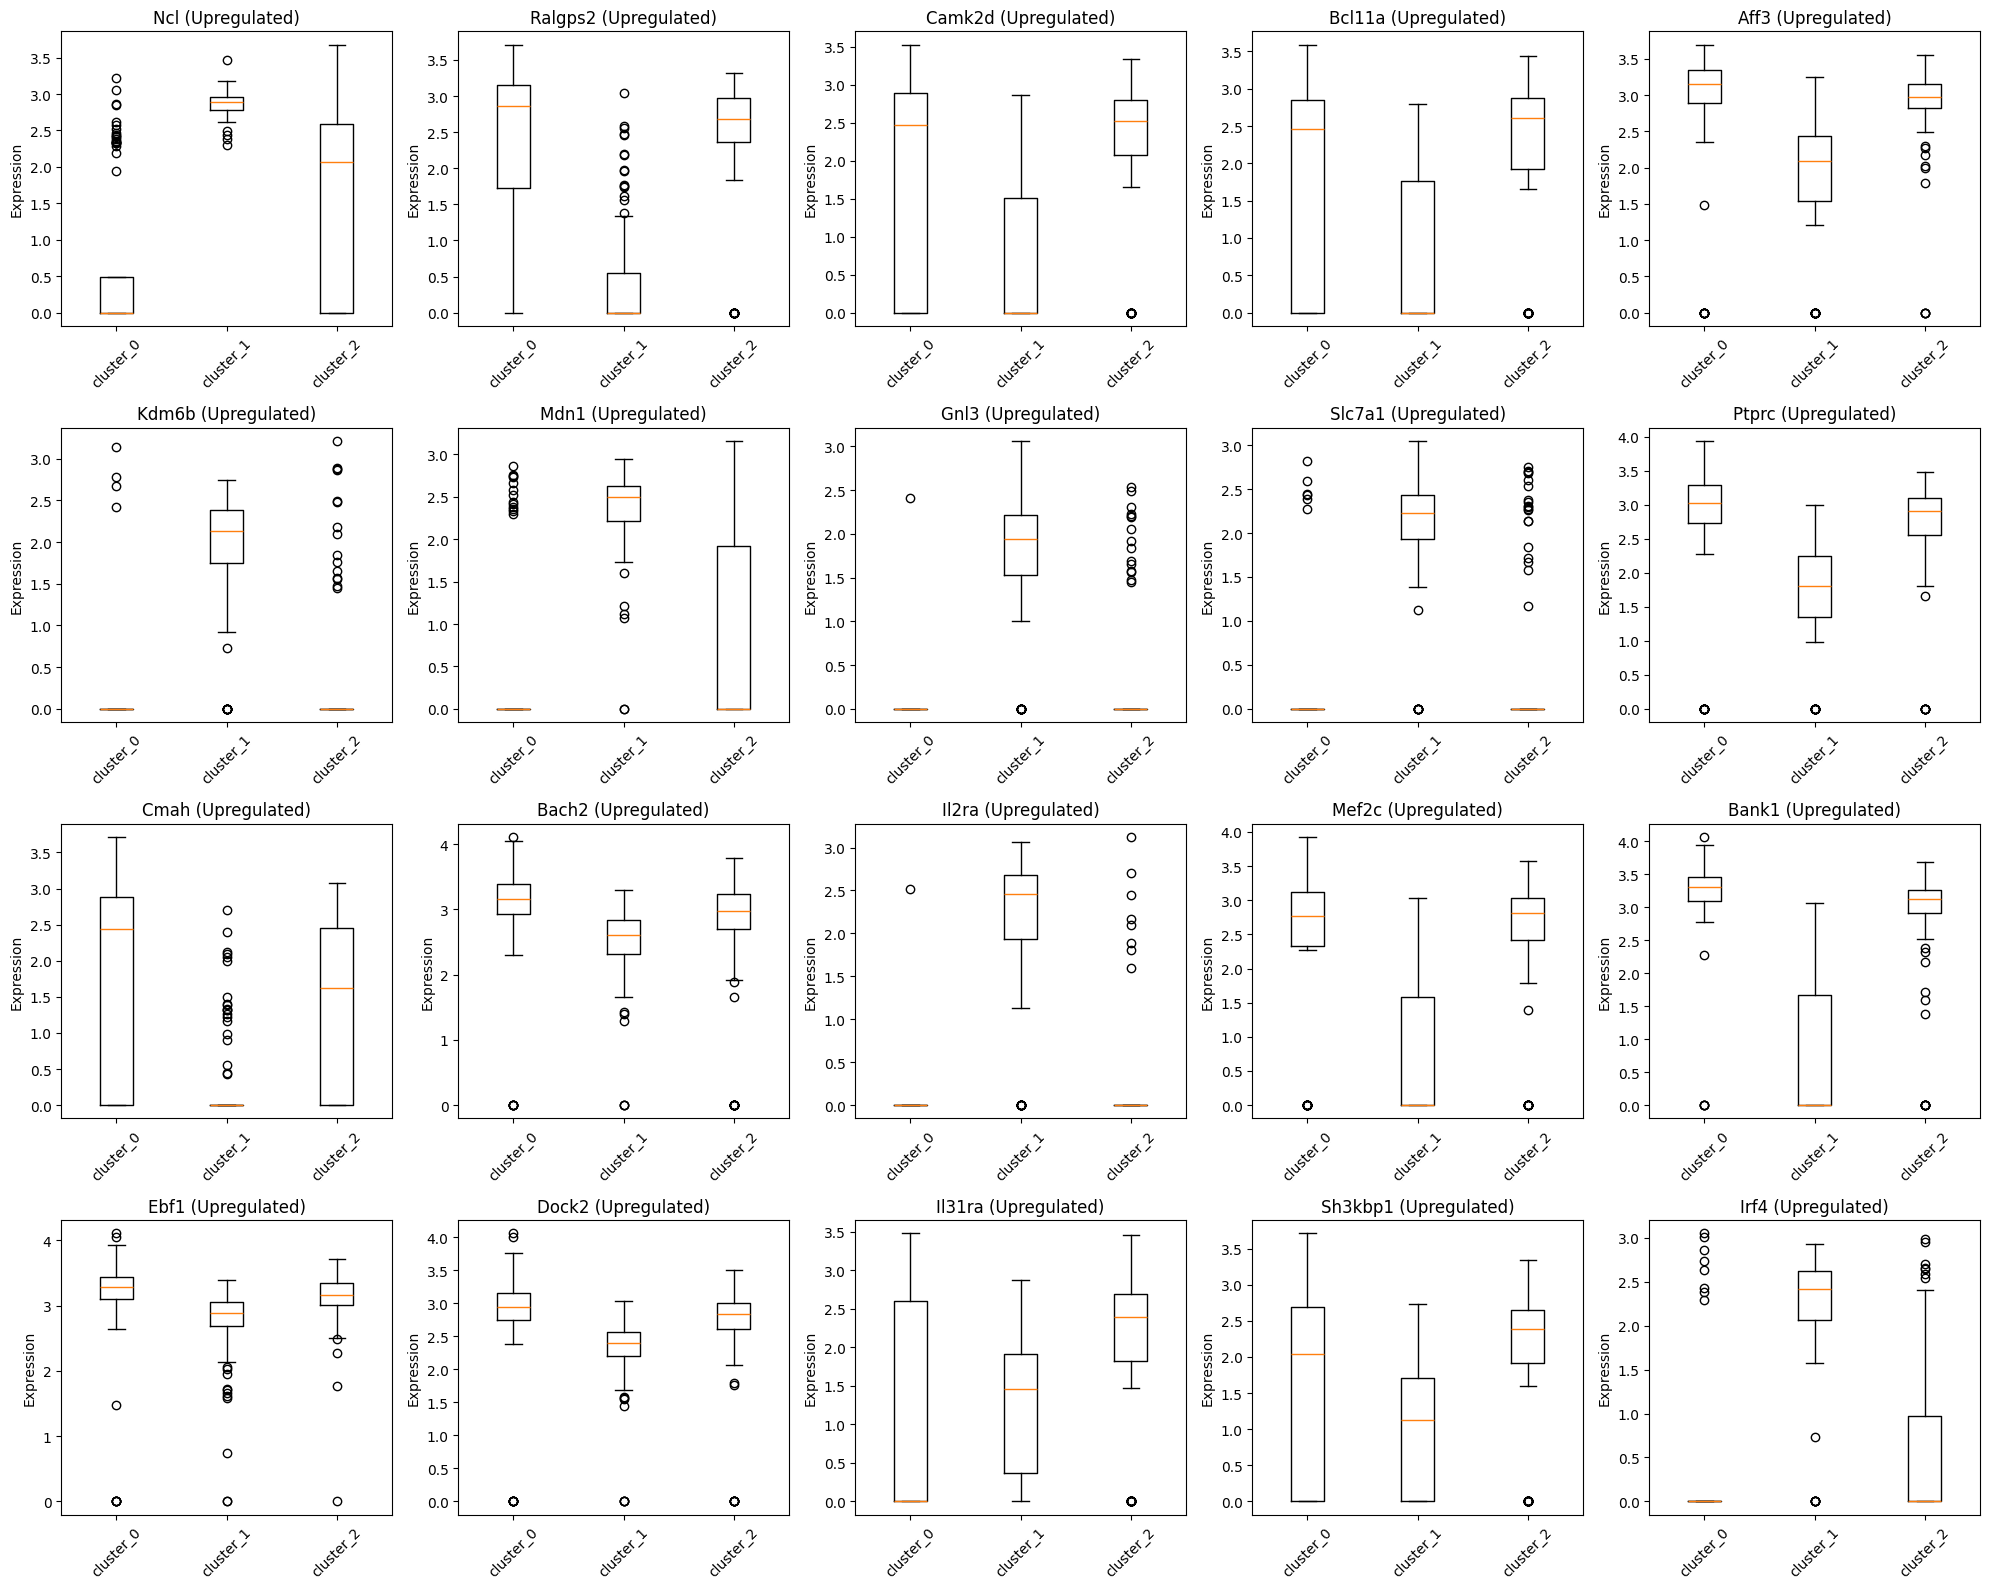


--- Box Plots for Downregulated Genes ---


/tmp/ipykernel_7713/1015343757.py:137: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/1015343757.py:137: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/1015343757.py:137: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/1015343757.py:137: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.

/tmp/ipykernel_7713/1015343757.py:137: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; s

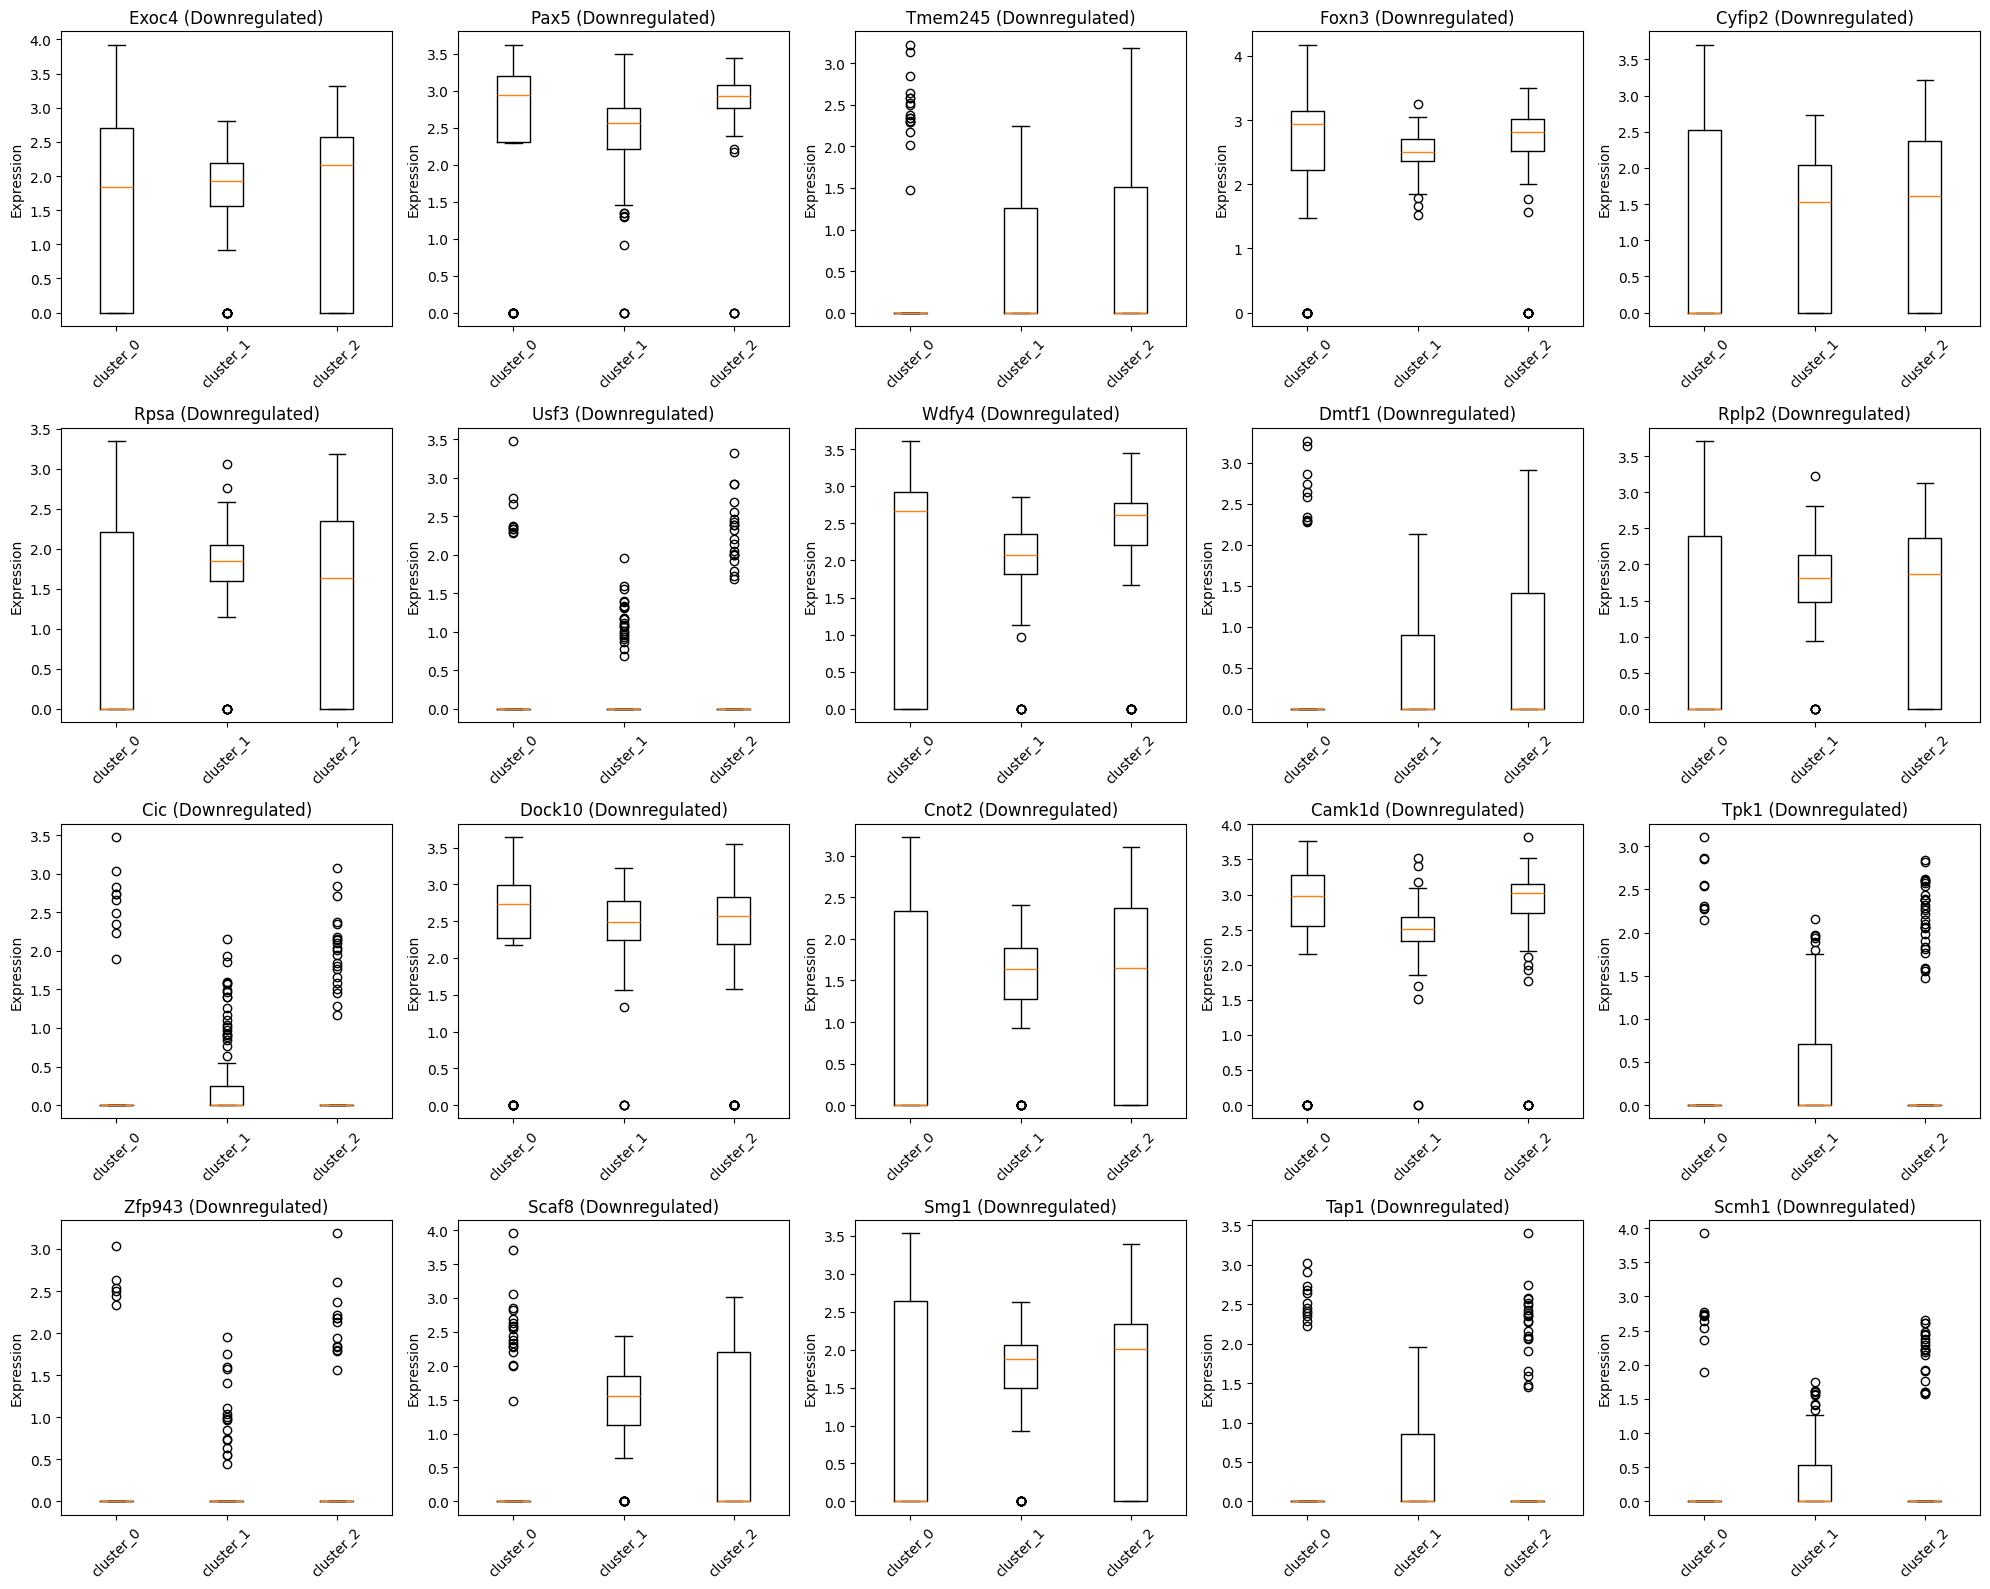


--- Top genes specific to cluster_0 ---
    gene    score        p_adj  logfoldchange
   Bank1 8.082135 6.601274e-12       1.696892
Arhgap15 7.558502 1.480226e-10       1.003160
   Cmss1 6.492207 1.535413e-07       0.572775
    Aff3 6.290647 4.918779e-07       0.551547
   Macf1 5.821280 5.782007e-06       0.771466
    Cmah 5.694424 9.629924e-06       1.947557
   Bach2 5.678215 9.882355e-06       0.466199
   Ptprc 5.642977 1.008093e-05       0.601960
   Dock2 5.625358 1.008093e-05       0.320156
    Ebf1 5.587301 1.059374e-05       0.166133
   Snx29 5.401246 2.402547e-05       1.509923
   Foxp1 5.349798 2.820522e-05       0.135158
  Fchsd2 5.127800 7.071627e-05       0.666190
   Nedd9 5.117934 7.157959e-05       0.734116
   Prkcb 4.996716 1.159242e-04       0.109101

--- Top genes specific to cluster_1 ---
   gene     score        p_adj  logfoldchange
    Ncl 12.229902 7.812347e-31       2.938972
  Il2ra 11.264062 4.300694e-26       6.066314
  Kdm6b 11.037885 4.305970e-25       4.65935

In [174]:
# Compare gene expression between clusters using scanpy
print("=== Gene Expression Analysis Between Clusters ===")

# Create AnnData object from the combined expression matrix
# First, separate expression data from cluster labels
expr_data = all_cluster_expr.drop('cluster', axis=1)
cluster_labels = all_cluster_expr['cluster']

# Create AnnData object
adata_clusters = ad.AnnData(X=expr_data.values, 
                           obs=pd.DataFrame({'cluster': cluster_labels}, index=expr_data.index),
                           var=pd.DataFrame(index=expr_data.columns))

# Normalize and log transform
sc.pp.normalize_total(adata_clusters, target_sum=1e4)
sc.pp.log1p(adata_clusters)

# Perform differential gene expression analysis between clusters
print("\n=== Differential Gene Expression Analysis ===")

# Get unique clusters
unique_clusters = adata_clusters.obs['cluster'].unique()
print(f"Clusters to compare: {unique_clusters}")

# Perform one-vs-rest analysis for each cluster
print("\n=== One-vs-Rest Analysis for Each Cluster ===")

sc.tl.rank_genes_groups(adata_clusters, 'cluster', method='wilcoxon')

# Get results for each cluster
result = adata_clusters.uns['rank_genes_groups']
groups = result['names'].dtype.names

# Create box plots for top differentially expressed genes
print("\n=== Creating Box Plots for Top Genes ===")

# Get top genes from each cluster (upregulated)
top_upregulated_genes = set()
for group in groups:
    gene_names = result['names'][group][:10]  # Top 10 upregulated genes per cluster
    top_upregulated_genes.update(gene_names)

# Get top genes from each cluster (downregulated)
top_downregulated_genes = set()
for group in groups:
    # Get downregulated genes (negative logfoldchange)
    gene_names = result['names'][group]
    logfoldchanges = result['logfoldchanges'][group]
    downregulated_indices = np.where(logfoldchanges < 0)[0]
    if len(downregulated_indices) > 0:
        downregulated_genes = gene_names[downregulated_indices][:10]  # Top 10 downregulated
        top_downregulated_genes.update(downregulated_genes)

# Filter to genes that are in our dataset
top_upregulated_genes = [gene for gene in top_upregulated_genes if gene in adata_clusters.var_names]
top_downregulated_genes = [gene for gene in top_downregulated_genes if gene in adata_clusters.var_names]

print(f"Total unique upregulated genes: {len(top_upregulated_genes)}")
print(f"Total unique downregulated genes: {len(top_downregulated_genes)}")

# Create box plots for upregulated genes
if len(top_upregulated_genes) > 0:
    print("\n--- Box Plots for Upregulated Genes ---")
    
    # Calculate number of subplots needed
    n_genes = min(len(top_upregulated_genes), 20)  # Limit to 20 genes for visualization
    n_cols = 5
    n_rows = (n_genes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, gene in enumerate(top_upregulated_genes[:n_genes]):
        row = i // n_cols
        col = i % n_cols
        
        # Get expression data for this gene
        gene_expr = adata_clusters[:, gene].X.flatten()
        clusters = adata_clusters.obs['cluster']
        
        # Create box plot data
        plot_data = []
        cluster_names = []
        for cluster in unique_clusters:
            cluster_mask = clusters == cluster
            if np.any(cluster_mask):
                plot_data.append(gene_expr[cluster_mask])
                cluster_names.append(cluster)
        
        # Create box plot
        axes[row, col].boxplot(plot_data, labels=cluster_names)
        axes[row, col].set_title(f'{gene} (Upregulated)')
        axes[row, col].set_ylabel('Expression')
        axes[row, col].tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for i in range(n_genes, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Create box plots for downregulated genes
if len(top_downregulated_genes) > 0:
    print("\n--- Box Plots for Downregulated Genes ---")
    
    # Calculate number of subplots needed
    n_genes = min(len(top_downregulated_genes), 20)  # Limit to 20 genes for visualization
    n_cols = 5
    n_rows = (n_genes + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, gene in enumerate(top_downregulated_genes[:n_genes]):
        row = i // n_cols
        col = i % n_cols
        
        # Get expression data for this gene
        gene_expr = adata_clusters[:, gene].X.flatten()
        clusters = adata_clusters.obs['cluster']
        
        # Create box plot data
        plot_data = []
        cluster_names = []
        for cluster in unique_clusters:
            cluster_mask = clusters == cluster
            if np.any(cluster_mask):
                plot_data.append(gene_expr[cluster_mask])
                cluster_names.append(cluster)
        
        # Create box plot
        axes[row, col].boxplot(plot_data, labels=cluster_names)
        axes[row, col].set_title(f'{gene} (Downregulated)')
        axes[row, col].set_ylabel('Expression')
        axes[row, col].tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for i in range(n_genes, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Print summary of top genes for each cluster
for group in groups:
    print(f"\n--- Top genes specific to {group} ---")
    gene_names = result['names'][group][:15]
    scores = result['scores'][group][:15]
    pvals = result['pvals_adj'][group][:15]
    logfoldchanges = result['logfoldchanges'][group][:15]
    
    # Create DataFrame for better visualization
    top_genes_df = pd.DataFrame({
        'gene': gene_names,
        'score': scores,
        'p_adj': pvals,
        'logfoldchange': logfoldchanges
    })
    
    print(top_genes_df.to_string(index=False))

# Statistical summary
print("\n=== Statistical Summary ===")
print(f"Total samples analyzed: {len(adata_clusters)}")
print(f"Total genes analyzed: {adata_clusters.n_vars}")
print(f"Number of clusters: {len(unique_clusters)}")

# Save results
print("\n=== Saving Results ===")
# Save differential expression results
for group in groups:
    gene_names = result['names'][group]
    scores = result['scores'][group]
    pvals = result['pvals_adj'][group]
    logfoldchanges = result['logfoldchanges'][group]
    
    # Create DataFrame
    de_results = pd.DataFrame({
        'gene': gene_names,
        'score': scores,
        'p_adj': pvals,
        'logfoldchange': logfoldchanges
    })
    
    # Save to CSV
    filename = f'cluster_{group}_differential_expression.csv'
    de_results.to_csv(filename, index=False)
    print(f"Saved {group} results to: {filename}")

print("Gene expression analysis complete!")


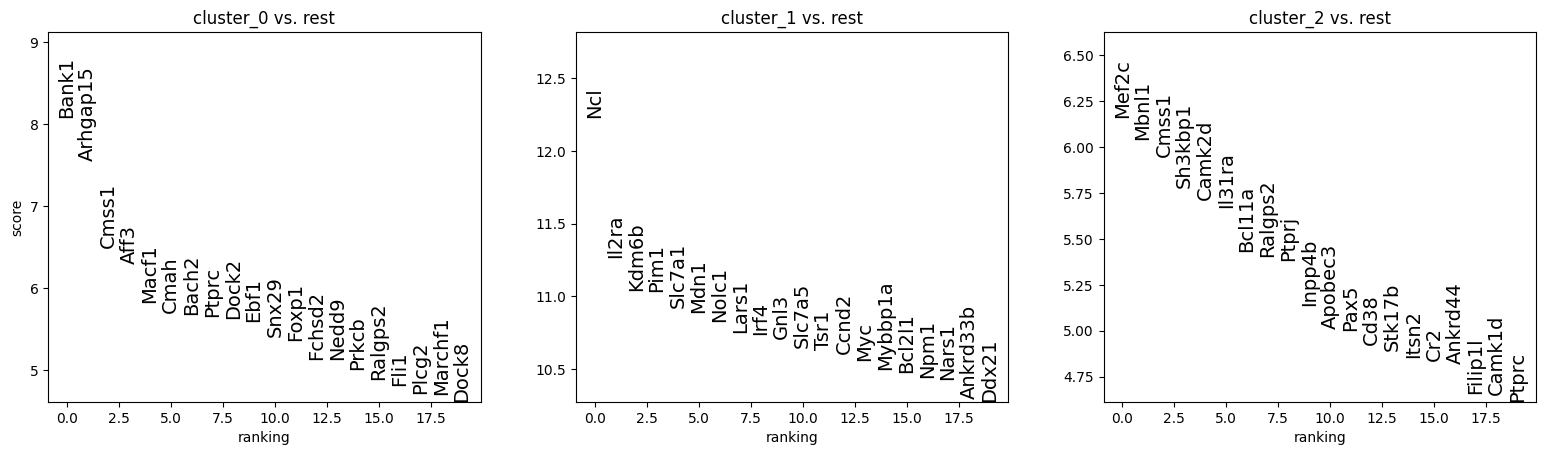


=== Gene Rank Summary Statistics ===

Cluster cluster_0:
  Total genes: 10891
  Significant genes (p<0.05): 919
  Upregulated: 48
  Downregulated: 871
  Max log fold change: 26.712
  Min log fold change: -29.656

Cluster cluster_1:
  Total genes: 10891
  Significant genes (p<0.05): 3255
  Upregulated: 3036
  Downregulated: 219
  Max log fold change: 28.500
  Min log fold change: -27.586

Cluster cluster_2:
  Total genes: 10891
  Significant genes (p<0.05): 523
  Upregulated: 118
  Downregulated: 405
  Max log fold change: 26.831
  Min log fold change: -28.318

Gene rank plots complete!


In [180]:
# Create gene rank plots using scanpy's built-in functionality
# This shows the distribution of gene expression differences

# Use scanpy's rank_genes_groups plotting function with smaller font size
sc.pl.rank_genes_groups(adata_clusters, n_genes=20, sharey=False, figsize=(16, 12), fontsize=14)

# Create summary statistics for each cluster comparison
print("\n=== Gene Rank Summary Statistics ===")
for group in groups:
    gene_names = result['names'][group]
    scores = result['scores'][group]
    pvals = result['pvals_adj'][group]
    logfoldchanges = result['logfoldchanges'][group]
    
    # Count significant genes
    sig_up = sum((pvals < 0.05) & (logfoldchanges > 0))
    sig_down = sum((pvals < 0.05) & (logfoldchanges < 0))
    total_sig = sig_up + sig_down
    
    print(f"\nCluster {group}:")
    print(f"  Total genes: {len(gene_names)}")
    print(f"  Significant genes (p<0.05): {total_sig}")
    print(f"  Upregulated: {sig_up}")
    print(f"  Downregulated: {sig_down}")
    print(f"  Max log fold change: {max(logfoldchanges):.3f}")
    print(f"  Min log fold change: {min(logfoldchanges):.3f}")

print("\nGene rank plots complete!")


Starting comparison: Cluster 2 samples vs. all Cyto Label=1 samples
Found Group 1 (cluster_2) with 134 samples.
Found Group 2 (label_1) with 606 samples.

Combined AnnData object created with shape: (740, 10891)
Ensuring var_names are unique...
Successfully set unique var_names.

Running DGE analysis...


/tmp/ipykernel_7713/1877650098.py:57: FutureWarning:

Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html



DGE analysis complete.

=== Top Genes Upregulated in 'cluster_2' (compared to 'label_1') ===


/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:480: RuntimeWarning:

overflow encountered in expm1

/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning:

divide by zero encountered in log2



,gene,logfoldchanges,pvals,pvals_adj,scores
0,ENSMUSG00000036469,3.149340,1.137292e-18,2.118857e-17,8.820717
1,ENSMUSG00000004568,1.996485,1.226952e-12,1.661485e-11,7.102303
2,ENSMUSG00000026616,4.071329,2.784290e-12,3.699193e-11,6.988203
3,ENSMUSG00000097705,1.342513,8.878183e-11,1.090595e-09,6.484915
4,ENSMUSG00000005540,2.067372,1.842679e-09,2.107345e-08,6.011101
5,ENSMUSG00000044770,2.120485,1.222106e-06,1.170766e-05,4.852019
6,ENSMUSG00000050600,1.402248,1.332619e-06,1.273212e-05,4.834826
7,ENSMUSG00000036478,1.125636,5.226241e-06,4.798647e-05,4.555495
8,ENSMUSG00000089809,1.684759,9.841372e-06,8.870460e-05,4.420630
9,ENSMUSG00000024399,2.399886,1.628495e-05,1.444764e-04,4.310549


Saved full results to 'dge_cluster2_vs_label1.csv'

=== Visualizing Top Differentially Expressed Genes ===

Volcano plot for 'cluster_2' vs 'label_1':


/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/matplotlib/transforms.py:351: RuntimeWarning:

invalid value encountered in scalar subtract



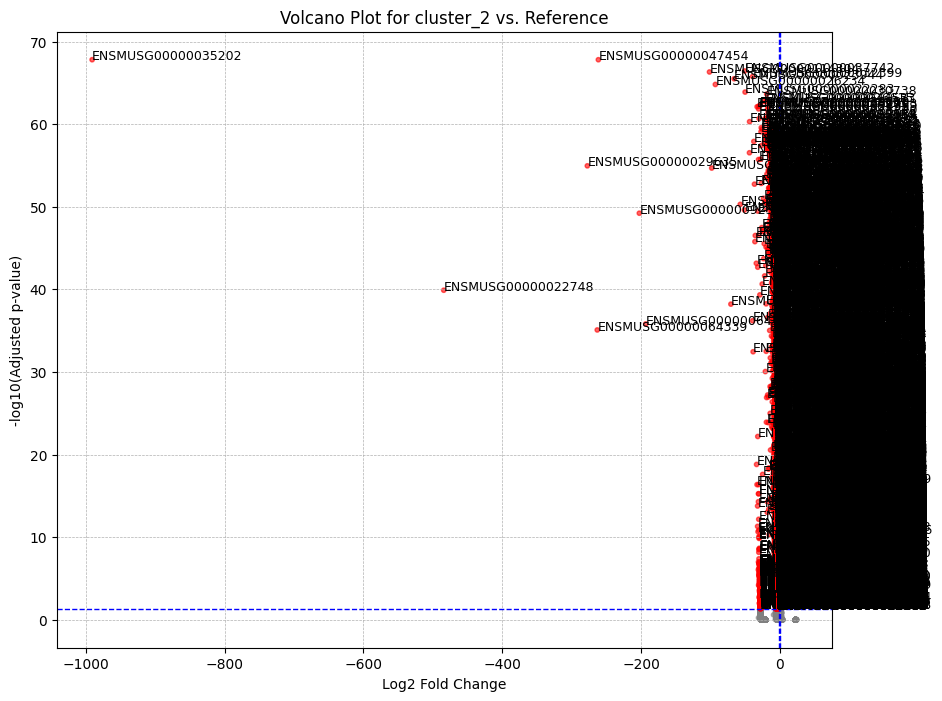


Heatmap of top 50 genes:


/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:138: UserWarning:

You’re trying to run this on 10891 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.



categories: cluster_2, label_1
var_group_labels: cluster_2


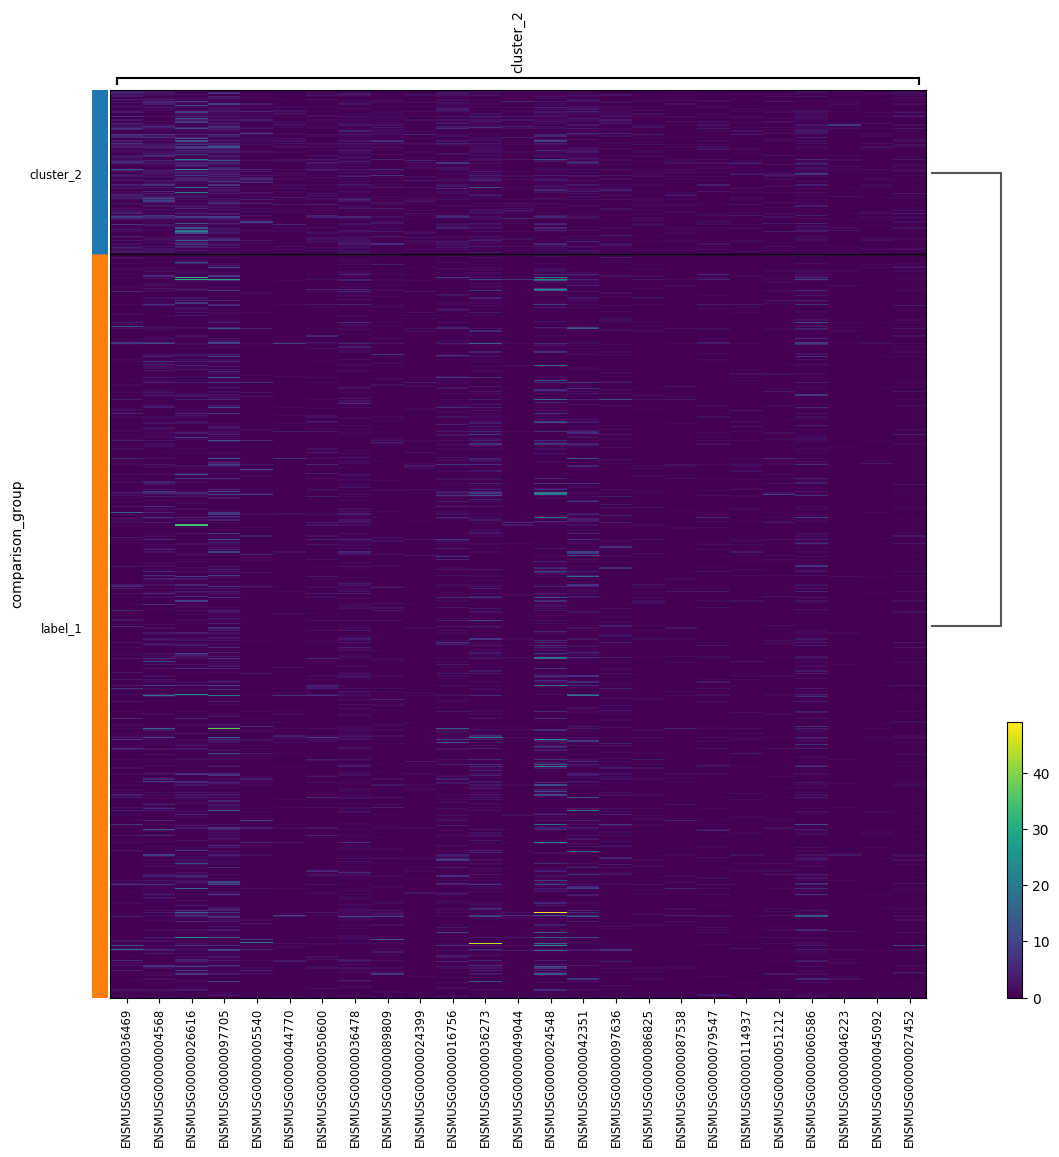


Violin plots for top 10 upregulated genes in 'cluster_2':


/home/FCAM/tyasenpoor/miniconda3/envs/bray_cpu/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1328: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



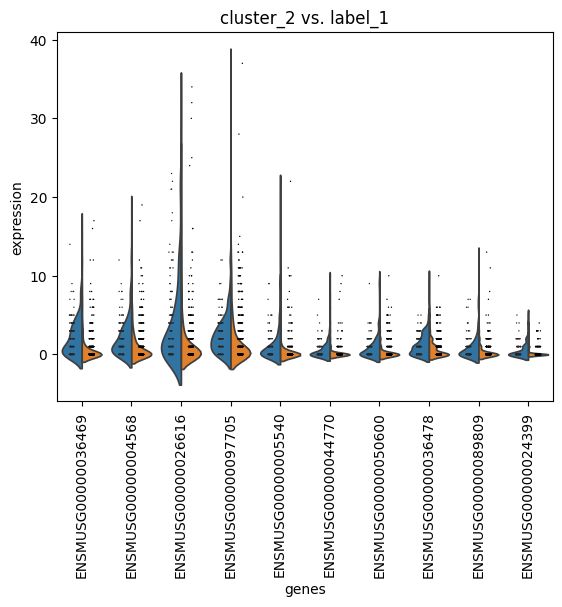

In [204]:
# === DGE Analysis: Cluster 2 vs. Cyto Label 1 (Corrected) ===
print("Starting comparison: Cluster 2 samples vs. all Cyto Label=1 samples")

# --- Helper function to create a volcano plot (since sc.pl.volcano is not standard) ---
def custom_volcano_plot(adata, group, pval_cutoff=0.05, lfc_cutoff=1.0):
    """
    Creates a volcano plot from rank_genes_groups results.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Extract results for the specified group
    result_df = get_rank_genes_df(adata, group)
    
    # Add significance flags
    result_df['significant'] = (result_df['pvals_adj'] < pval_cutoff) & (abs(result_df['logfoldchanges']) > lfc_cutoff)
    result_df['gene_label'] = result_df.apply(lambda row: row['gene'] if row['significant'] else '', axis=1)

    # Create the plot
    plt.figure(figsize=(10, 8))
    plt.scatter(
        result_df['logfoldchanges'],
        -np.log10(result_df['pvals_adj'].replace(0, 1e-300)), # Replace 0 p-values
        c=result_df['significant'].map({True: 'red', False: 'grey'}),
        alpha=0.6,
        s=10
    )
    
    # Add labels for significant genes
    for i, row in result_df[result_df['significant']].iterrows():
        plt.text(row['logfoldchanges'], -np.log10(row['pvals_adj']), row['gene_label'], fontsize=9)
        
    plt.axhline(-np.log10(pval_cutoff), color='blue', linestyle='--', lw=1)
    plt.axvline(lfc_cutoff, color='blue', linestyle='--', lw=1)
    plt.axvline(-lfc_cutoff, color='blue', linestyle='--', lw=1)
    
    plt.title(f"Volcano Plot for {group} vs. Reference")
    plt.xlabel("Log2 Fold Change")
    plt.ylabel("-log10(Adjusted p-value)")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# 1. Get the two sample groups
try:
    adata_cluster_2 = cluster_expression_data['cluster_2'].copy()
    adata_cluster_2.obs['comparison_group'] = 'cluster_2'
    print(f"Found Group 1 (cluster_2) with {adata_cluster_2.n_obs} samples.")
except NameError:
    print("Error: Could not find `cluster_expression_data`. Please run the previous cell first.")
    raise

adata_label_1 = ajm_cyto_filtered[ajm_cyto_filtered.obs['cyto'] == 1].copy()
adata_label_1.obs['comparison_group'] = 'label_1'
print(f"Found Group 2 (label_1) with {adata_label_1.n_obs} samples.")

# 2. Concatenate the two AnnData objects
adata_comparison = adata_cluster_2.concatenate(adata_label_1, join='inner')
print(f"\nCombined AnnData object created with shape: {adata_comparison.shape}")

# 3. Ensure var_names are unique (skip gene symbol conversion)
print("Ensuring var_names are unique...")
adata_comparison.var_names_make_unique()
print("Successfully set unique var_names.")

# 4. Perform Differential Gene Expression (DGE) analysis
print("\nRunning DGE analysis...")
sc.tl.rank_genes_groups(
    adata_comparison,
    groupby='comparison_group',
    method='wilcoxon',
    pts=True,
    reference='label_1' # Compare cluster_2 against label_1
)
print("DGE analysis complete.")

# 5. Display the results
print("\n" + "="*80)
print("=== Top Genes Upregulated in 'cluster_2' (compared to 'label_1') ===")
print("="*80)
cluster_2_results = get_rank_genes_df(adata_comparison, 'cluster_2')
display(cluster_2_results.head(20))
cluster_2_results.to_csv('dge_cluster2_vs_label1.csv', index=False)
print("Saved full results to 'dge_cluster2_vs_label1.csv'")

# 6. Visualize the results
print("\n" + "="*80)
print("=== Visualizing Top Differentially Expressed Genes ===")
print("="*80)

# Custom Volcano Plot
print("\nVolcano plot for 'cluster_2' vs 'label_1':")
custom_volcano_plot(adata_comparison, group='cluster_2')

# Heatmap of top 50 differentiating genes
print("\nHeatmap of top 50 genes:")
sc.pl.rank_genes_groups_heatmap(adata_comparison, n_genes=25, groupby='comparison_group', show_gene_labels=True, figsize=(12, 12))

# Violin plots of the top 10 most upregulated genes in cluster_2
print("\nViolin plots for top 10 upregulated genes in 'cluster_2':")
sc.pl.rank_genes_groups_violin(adata_comparison, groups=['cluster_2'], n_genes=10)


Violin plots for top 10 upregulated genes in 'cluster_2' (gene symbols):


AttributeError: FillBetweenPolyCollection.set() got an unexpected keyword argument 'return_fig'

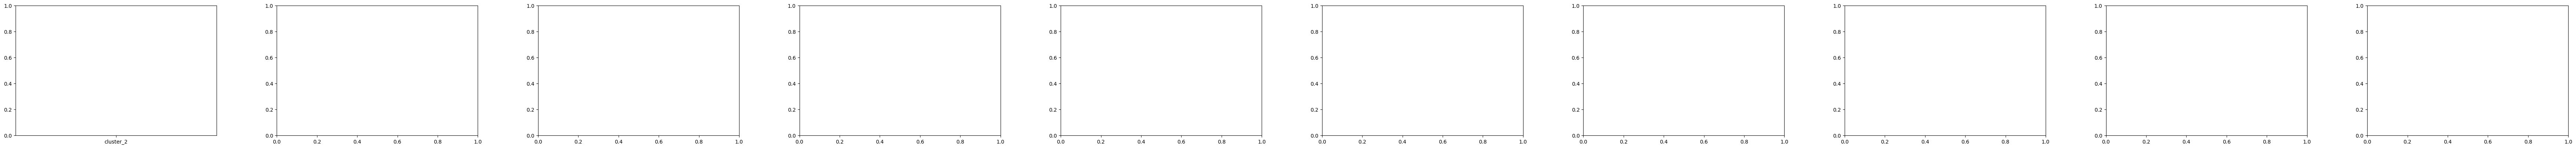

: 

In [213]:
# Violin plots of the top 10 most upregulated genes in cluster_2 (showing gene symbols)
print("\nViolin plots for top 10 upregulated genes in 'cluster_2' (gene symbols):")

# Get the top 10 genes from cluster_2
top_genes = get_rank_genes_df(adata_comparison, 'cluster_2').head(10)['gene'].tolist()

import matplotlib.pyplot as plt

# Plot violin plots for the top genes, grouped by 'comparison_group'
# Workaround: Do NOT use the 'groups' argument, which causes the AttributeError in recent Scanpy/Matplotlib
fig = sc.pl.violin(
    adata_comparison,
    keys=top_genes,
    groupby='comparison_group',
    stripplot=False,
    rotation=90,
    show=False,
    return_fig=True
)

# Try to extract the gene names from the plot (x-axis tick labels)
ax = fig.axes[0] if hasattr(fig, "axes") and len(fig.axes) > 0 else plt.gca()
ensembl_labels = [tick.get_text() for tick in ax.get_xticklabels()]

# Map Ensembl IDs to gene symbols if possible
if 'gene_symbols' in adata_comparison.var.columns:
    gene_symbols = []
    for g in ensembl_labels:
        if g in adata_comparison.var_names:
            symbol = adata_comparison.var.loc[g, 'gene_symbols']
            gene_symbols.append(symbol if pd.notnull(symbol) else g)
        else:
            gene_symbols.append(g)
else:
    gene_symbols = ensembl_labels

print(f"Top 10 gene symbols (from plot x-axis): {gene_symbols}")

# Relabel the x-axis with gene symbols
ax.set_xticklabels(gene_symbols, rotation=90)
plt.tight_layout()
plt.show()


In [199]:
# Extract cluster_2 samples from the clustered data
cluster_2_samples = adata_comparison.obs[adata_comparison.obs['comparison_group'] == 'cluster_2']['sample_id'].tolist()
print(f"Found {len(cluster_2_samples)} samples in cluster_2")

# Extract samples with true label 1 from ajm_cyto_filtered dataset
true_label_1_samples = ajm_cyto_filtered.obs[ajm_cyto_filtered.obs['cyto'] == 1]['sample_id'].tolist()
print(f"Found {len(true_label_1_samples)} samples with true label 1")

# Create a combined list of samples for analysis
combined_samples = cluster_2_samples + true_label_1_samples
print(f"Total samples for analysis: {len(combined_samples)}")

# Create a new AnnData object with these samples
adata_combined = adata[adata.obs['sample_id'].isin(combined_samples)].copy()

# Add comparison group labels
adata_combined.obs['comparison_group'] = 'label_1'  # Default to label_1
adata_combined.obs.loc[adata_combined.obs['sample_id'].isin(cluster_2_samples), 'comparison_group'] = 'cluster_2'

# Verify the grouping
print("\nSample distribution:")
print(adata_combined.obs['comparison_group'].value_counts())

# Display the new dataset info
print(f"\nNew dataset shape: {adata_combined.shape}")
print(f"Comparison groups: {adata_combined.obs['comparison_group'].unique()}")


Found 134 samples in cluster_2
Found 606 samples with true label 1
Total samples for analysis: 740

Sample distribution:
comparison_group
cluster_2    134
Name: count, dtype: int64

New dataset shape: (134, 10891)
Comparison groups: ['cluster_2']


In [203]:
# Concatenate the two sample groups and extract gene expression data
print("Concatenating sample groups and extracting gene expression data...")

# Get the gene expression matrix for the combined samples
X_combined = adata_combined.X.toarray() if hasattr(adata_combined.X, 'toarray') else adata_combined.X

# Create a DataFrame with gene expression data
gene_expr_df = pd.DataFrame(X_combined, 
                           index=adata_combined.obs['sample_id'],
                           columns=adata_combined.var_names)

# Add the comparison group column
gene_expr_df['comparison_group'] = adata_combined.obs['comparison_group'].values

# Get 606 samples with true label 1 from ajm_cyto_filtered
true_label_1_samples_606 = ajm_cyto_filtered.obs[ajm_cyto_filtered.obs['cyto'] == 1]['sample_id'].head(606).tolist()

# Get gene expression data for these 606 samples
X_label_1_606 = adata[adata.obs['sample_id'].isin(true_label_1_samples_606)].X.toarray() if hasattr(adata[adata.obs['sample_id'].isin(true_label_1_samples_606)].X, 'toarray') else adata[adata.obs['sample_id'].isin(true_label_1_samples_606)].X

# Create DataFrame for the 606 samples
label_1_606_df = pd.DataFrame(X_label_1_606,
                              index=true_label_1_samples_606,
                              columns=adata.var_names)
label_1_606_df['comparison_group'] = 'label_1'

# Concatenate the two DataFrames
gene_expr_df = pd.concat([gene_expr_df, label_1_606_df], axis=0, ignore_index=False)

# Move comparison_group to the front for better visibility
cols = gene_expr_df.columns.tolist()
cols.insert(0, cols.pop(cols.index('comparison_group')))
gene_expr_df = gene_expr_df[cols]

# Display the results
print(f"\nFinal gene expression DataFrame shape: {gene_expr_df.shape}")
print(f"Number of samples in cluster_2: {(gene_expr_df['comparison_group'] == 'cluster_2').sum()}")
print(f"Number of samples in label_1: {(gene_expr_df['comparison_group'] == 'label_1').sum()}")

print("\nFirst few rows and columns:")
print(gene_expr_df.iloc[:5, :10])

print("\nSample of gene names (first 10):")
gene_columns = [col for col in gene_expr_df.columns if col != 'comparison_group']
print(gene_columns[:10])


Concatenating sample groups and extracting gene expression data...


ValueError: Empty data passed with indices specified.